In [302]:
""" import useful functions """

import matplotlib.pyplot as plt 
from scipy.integrate import odeint, solve_bvp
import pyccl as ccl
import numpy as np
import scipy
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import mpmath as mp
from decimal import Decimal, getcontext
from scipy import interpolate

%matplotlib inline

## Define useful functions

In [303]:
""" define background functions """

# Equation 2.14
def Omega_Lambda(cosmo):
    Omega_c , Omega_b , Omega_k , Omega_r, alpha_tilde, C_t = cosmo
    Omega_m = Omega_c + Omega_b
    
    return 1 - Omega_m - Omega_r - Omega_k + alpha_tilde * (1 - C_t**2 + Omega_k**2 - 2*Omega_k)

# Equation 2.13
def X(z, cosmo):
    
    Omega_c , Omega_b , Omega_k , Omega_r, alpha_tilde, C_t = cosmo
    Omega_m = Omega_c + Omega_b
    Omega_lambda = Omega_Lambda(cosmo)
    
    return 1 + 4 * alpha_tilde * (Omega_m * (1 + z) ** 3 + (Omega_r + alpha_tilde*C_t**2) * (1 + z)** 4 + Omega_lambda)

# Equation 2.12
def E(z , cosmo):
    
    Omega_c , Omega_b , Omega_k , Omega_r, alpha_tilde, C_t = cosmo
    Omega_m = Omega_c + Omega_b
    Omega_lambda = Omega_Lambda(cosmo)
    
    if alpha_tilde == 0:
        ans = np.sqrt(Omega_m * (1 + z) ** 3 + Omega_r * (1 + z) ** 4 + Omega_k * (1 + z) ** 2 + Omega_lambda)
    else:
        ans = np.sqrt((np.sqrt(X(z , cosmo)) - 1 + (2 * alpha_tilde * Omega_k * (1+z) ** 2))/(2 * alpha_tilde))
    
    return ans

# gives dE/dz

def dEdz(z , cosmo):
    
    Omega_c , Omega_b , Omega_k , Omega_r, alpha_tilde, C_t = cosmo
    Omega_m = Omega_c + Omega_b
    Omega_lambda = Omega_Lambda(cosmo)
    
    # Wang and Mota
    dEdz = Omega_k *(1 + z)/E(z , cosmo) + ((3 * Omega_m * (1 + z) ** 2)+(4 * (Omega_r + alpha_tilde*C_t**2) * (1 + z) ** 3))/\
           (2 * E(z , cosmo) * np.sqrt(X(z , cosmo)))
    
    return dEdz

# gives rho_cdm / rho_DE as a function of z for k = 0


def rho_cdm_frac_rho_de(z , cosmo):
    Omega_c , Omega_b , Omega_k , Omega_r, alpha_tilde, C_t = cosmo
    Omega_m = Omega_c + Omega_b
    Omega_lambda = Omega_Lambda(cosmo)
    
    E_eval = E(z, cosmo)
    
    frac = Omega_c * (1+z) ** 3 / (Omega_lambda - alpha_tilde*(E_eval ** 4 - 2 * Omega_k * E_eval ** 2 * (1 + z) ** 2))
    return frac

# find w = P / pho for dark energy   -- for k = 0


def omega_de(z , cosmo):
    
    Omega_c , Omega_b , Omega_k , Omega_r, alpha_tilde, C_t = cosmo
    Omega_m = Omega_c + Omega_b
    Omega_lambda = Omega_Lambda(cosmo)
    
    E_eval = E(z, cosmo)
    
    ans = - 1 - (4 * alpha_tilde * (1 + z) * E_eval ** 3 * dEdz(z , cosmo)) / \
                (3 * (Omega_lambda - alpha_tilde*(E_eval ** 4)))
    
    return ans


def unitless_time(a , cosmo):
    t = mp.quad(lambda x: 1/(x*E(1/x -1,cosmo)), [0 , a])
    return t

# sound horizon
def r_s_fracH0c(z,cosmo, a_min):
    Omg_c , Omg_b , Omg_k , Omg_r, alpha_t, C_t = cosmo
    Omg_m = Omg_b + Omg_c 
    
    return mp.quad(lambda x: 1/((x**2)*E(1/x -1, cosmo)*np.sqrt(3*(1 + R_b(Omg_b*h**2)*x))), [a_min, 1/(1+z)])

# particle horizon
def r_hor_fracH0c(z,cosmo, a_min):
    return mp.quad(lambda x: 1/((x**2)*E(1/x-1, cosmo)), [a_min, 1/(1+z)])

# Used to find z_CMB
def g1(wb):
    return (0.0783*wb**(-0.238))/(1 + 39.5*wb**(0.763))

# Used to find z_CMB
def g2(wb):
    return 0.56/(1 + 21.1*wb**(1.81))

# redshift at which the BB occurs
def z_CMB(Omg_b,Omg_m,h):
    wb = Omg_b * h**2
    wm = Omg_m * h**2
    return 1048*(1+0.00124*wb**(-0.738))*\
           (1 + g1(wb)*wm**g2(wb))

# Used to find r_s
def R_b(wb):
    return 31500*wb*(2.7255/2.7)**(-4)

def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx


In [304]:
"""  Define useful functions for growth """
# Define xi, caracteristic function of 4DEGB. xi(alpha_C = 1) = 1
# note: k is unitless (ie. k is actually k/H0)
def xi(a, cosmo1, k):
    Omega_c , Omega_b , Omega_k , Omega_r , alpha_C = cosmo1
    if alpha_C == 0:
        return 1
    else:
        Omega_m = Omega_c + Omega_b
        Omega_lambda = 1 - Omega_m - Omega_r - Omega_k - alpha_C
        return (k**2)*a**2/((k**2)*a**2 + 6*alpha_C)

# Define Ea^2 = H/H0 a^2 (a suqared to avoid singularity
def Easquared(a,cosmo1):
    Omega_c , Omega_b , Omega_k , Omega_r , alpha_C = cosmo1
    Omega_m = Omega_c + Omega_b
    Omega_lambda = 1 - Omega_m - Omega_r - Omega_k - alpha_C
    
    return np.sqrt(Omega_m*a + (Omega_r + alpha_C) + Omega_k*a**(2) + Omega_lambda*a**(4))

# FUNCTIONS FOR BVP

# Second order ODE for D_+(a)
def solverGrowth(a, y, cosmo1, k):
    Omega_c = cosmo1[0]
    Omega_b = cosmo1[1]
    Omega_m = Omega_c + Omega_b
    Easq_val = Easquared(a, cosmo1)
    D , a3EdDda = y
    return np.vstack(((a3EdDda / (Easq_val*a)), 3*Omega_m*D*xi(a, cosmo1, k)/(2*Easq_val)))

# BC for our ODE. D(a=0) = 0, D(a = 1) = 1
# can set value of either function (y[0] or y[1]) at the lower (a) or upper (b) limit
def bc(ya, yb):
    return np.array([ya[0], yb[0] - 1])

# Function that returns D, f for a given cosmo, a and k
def solve_for_growth(a, cosmo1, k):
    
    # x range over which to solve fun
    x = np.logspace(-20,0,100)
    # initial guess for value of functions (y_init = [y[0]_init,y[0]_init])
    y_init = np.zeros((2, x.size))
    y_init[0] = x
    D_val = np.zeros((len(k),len(a)))
    f_val = np.zeros((len(k),len(a)))
    for i in range(len(k)):
        soln = solve_bvp(lambda x, y: solverGrowth(x, y, cosmo1, k[i]), bc, x, y_init).sol(a)
        D_val[i] = soln[0]
        a3EDdot = soln[1]
        f_val[i] = a3EDdot/(D_val[i]*Easquared(a,cosmo1))
    return D_val, f_val

In [305]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

## Background

In [215]:
# SNe processed data for E(z) (with no correlation)

z_dat = np.array([0.07,0.2,0.35,0.55,0.9,1.5])

E_err = np.array([0.023,0.02,0.037,0.063,0.12,0.83])

E_dat = np.array([0.997,1.111,1.128,1.364,1.52,2.67])

In [216]:
'''cosmological parameters except alpha'''

Omg_rad = 5.44e-5 * 3.046 * (7/8) * (4/11)**(4/3)
cosmoLCDM = [0.264 , 0.0493 , 0 , Omg_rad, 0, 0]                      #  Omega_c , Omega_b , Omega_k , Omega_r, alpha_tilde, C_t


#define a and z intervals
z = np.linspace(0, 3 , int(1e3))
a = 1/(1+z)

In [217]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})
col = sns.color_palette("colorblind") 


/tmp/ipykernel_2495851/4236316675.py:29: RuntimeWarning: invalid value encountered in sqrt
  ans = np.sqrt((np.sqrt(X(z , cosmo)) - 1 + (2 * alpha_tilde * Omega_k * (1+z) ** 2))/(2 * alpha_tilde))


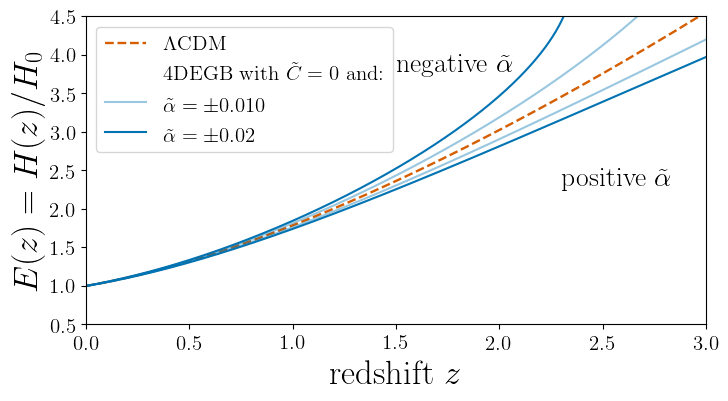

In [144]:
'''Plots of E(z)'''

# best combinations are 0,2,4,9 and 1,3,5,8. Grey is 7
plt.figure(figsize=(8,4))

plt.plot(z,E(z , cosmoLCDM), color = col[3],linestyle= "--",alpha=1,linewidth=1.7, label = r"$\Lambda\textrm{CDM}$")

plt.plot(0,0, alpha = 0, label = r"$\textrm{4DEGB with }\tilde{C} = 0 \textrm{ and:}$")
cosmo = [0.264 , 0.0493 , 0 , Omg_rad, 1e-2, 0]
plt.plot(z,E(z , cosmo), color = col[0], alpha = 0.4, label = r'$\tilde{\alpha} = \pm %.3f$' % cosmo[-2])

cosmo = [0.264 , 0.0493 , 0 , Omg_rad, 2e-2, 0]
plt.plot(z,E(z , cosmo), color = col[0], alpha = 1, label = r'$\tilde{\alpha} = \pm %.2f$' % cosmo[-2])

cosmo = [0.264 , 0.0493 , 0 , Omg_rad, 1e-1, 0]
#plt.plot(z,E(z , cosmo), color = col[0], alpha = 1, label = r'$\tilde{\alpha} =  \pm %.1f$' % cosmo[-2])

# -------
cosmo = [0.264 , 0.0493 , 0 , Omg_rad, -1e-2, 0]
plt.plot(z,E(z , cosmo), color = col[0], alpha = 0.4)

cosmo = [0.264 , 0.0493 , 0 , Omg_rad, -2e-2, 0]
plt.plot(z,E(z , cosmo), color = col[0], alpha = 1)

plt.text(2.3, 2.3, r"$\textrm{positive }\tilde{\alpha}$", fontfamily = "Helvetica", size = 20)
plt.text(1.5, 3.8, r"$\textrm{negative }\tilde{\alpha}$", fontfamily = "Helvetica", size = 20)

#plt.errorbar(z_dat, E_dat, yerr=E_err, fmt=".k", capsize=2)
plt.xlabel(r"$\textrm{redshift }z$", size = 25)
plt.ylabel(r"$E(z) = H(z)/H_0$", size = 25);
plt.xlim(0,3)
plt.ylim(0.5,4.5)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.legend(prop={'size': 15})
#plt.savefig("E_z_GL_paper.pdf", bbox_inches="tight")


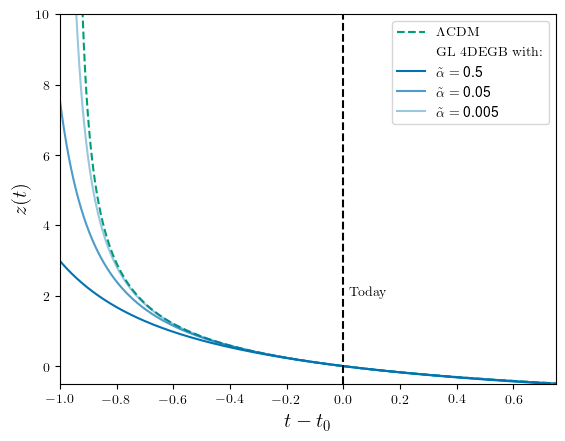

In [19]:
'''Plots of z(t)'''

z = np.linspace(-0.5, 10 , int(1e3))

plt.plot(unitless_time(z,cosmoLCDM) - unitless_time([0,0],cosmoLCDM)[0],z, color = col[2],linestyle= "--", label = r"$\Lambda \textrm{CDM}$")

plt.plot(0,0, alpha = 0, label = r"$\textrm{GL 4DEGB with:}$")

cosmo = [0.264 , 0.0493 , 0 , Omg_rad, 5e-1, 0]
plt.plot(unitless_time(z,cosmo) - unitless_time([0,0],cosmo)[0], z , color = col[0], alpha = 1, label = r'$\tilde{\alpha} =  $'+ " " +str(cosmo[-2]))
cosmo = [0.264 , 0.0493 , 0 , Omg_rad, 5e-2, 0]
plt.plot(unitless_time(z,cosmo) - unitless_time([0,0],cosmo)[0], z , color = col[0], alpha = 0.7, label = r'$\tilde{\alpha} =  $'+ " " +str(cosmo[-2]))
cosmo = [0.264 , 0.0493 , 0 , Omg_rad, 5e-3, 0]
plt.plot(unitless_time(z,cosmo) - unitless_time([0,0],cosmo)[0], z , color = col[0], alpha = 0.4, label = r'$\tilde{\alpha} =  $'+ " " +str(cosmo[-2]))
plt.plot(np.zeros(len(z)), z, "--k")
plt.text(0.02, 2.0, r"$\textrm{Today}$", fontfamily = "Helvetica")

plt.xlabel(r"$t - t_0$", size = 15)
plt.ylabel(r"$z(t)$", size = 15);
plt.legend()
plt.xlim(-1,0.75)
plt.ylim(-0.5,10)

#plt.savefig("z_of_t_paper.pdf")
plt.show()

In [1179]:
# find Planck scale factor from planck time
cosmo1 = [0.264 , 0.0493 , 0 , Omg_rad, 1e-15, 0]
cosmo2 = [0.264 , 0.0493 , 0 , Omg_rad, 1e-36, 0]
cosmo3 = [0.264 , 0.0493 , 0 , Omg_rad, 1e-43, 0]
cosmoLCDM = [0.264 , 0.0493 , 0 , Omg_rad, 0, 0]                      #  Omega_c , Omega_b , Omega_k , Omega_r, alpha_tilde, C_t

a_tofindtime = np.logspace(-60,-50, int(1e3))
t_planck = 5.391247e-44 #s
t_planck = t_planck * 67/(3.086e22) # unitless
print(t_planck)
t_array1 = np.zeros(len(a_tofindtime))
t_array2 = np.zeros(len(a_tofindtime))
t_array3 = np.zeros(len(a_tofindtime))
for i in range(len(a_tofindtime)):
    t_array1[i] = unitless_time(a_tofindtime[i] , cosmo1)
    t_array2[i] = unitless_time(a_tofindtime[i] , cosmo2)
    t_array2[i] = unitless_time(a_tofindtime[i] , cosmo2)
a_planck1 = a_tofindtime[find_nearest(t_array1, t_planck)]
a_planck2 = a_tofindtime[find_nearest(t_array2, t_planck)]
a_planck3 = a_tofindtime[find_nearest(t_array3, t_planck)]
print(a_planck3)
print("error in planck time during calculations = ", (t_array1[find_nearest(t_array1, t_planck)]-t_planck)/t_planck)

1.1704910855476345e-64
1e-60
error in planck time during calculations =  12.591941629865124


In [ ]:
'''Plots of Sound Horizon'''

mp.mp.dps = 150
h = 0.67
Omg_rad = (1 + (7/8) * (4/11)**(4/3)*3.046)*9.227e-5

#Find quantities
a1 = np.linspace(a_planck1,1.0, int(1e3))
a2 = np.linspace(a_planck2,1.0, int(1e3))
a3 = np.linspace(a_planck3,1.0, int(1e3))

r_s_LCDM1 = np.zeros(len(a1))
r_s_LCDM2 = np.zeros(len(a2))
r_s_LCDM3 = np.zeros(len(a3))
r_s1 = np.zeros(len(a1))
r_s2 = np.zeros(len(a2))
r_s3 = np.zeros(len(a3))

for i in range(len(a1)):
    r_s_LCDM1[i] = r_s_fracH0c(1/a1[i] - 1,cosmoLCDM, 0) #nucleosynthesis a_min = 2.5e-9
    r_s_LCDM2[i] = r_s_fracH0c(1/a2[i] - 1,cosmoLCDM, 0)
    r_s_LCDM3[i] = r_s_fracH0c(1/a3[i] - 1,cosmoLCDM, 0)
    r_s1[i] = r_s_fracH0c(1/a1[i] - 1 , cosmo1, a_planck1)
    r_s2[i] = r_s_fracH0c(1/a2[i] - 1 , cosmo2, a_planck2)
    r_s3[i] = r_s_fracH0c(1/a3[i] - 1 , cosmo3, a_planck3)

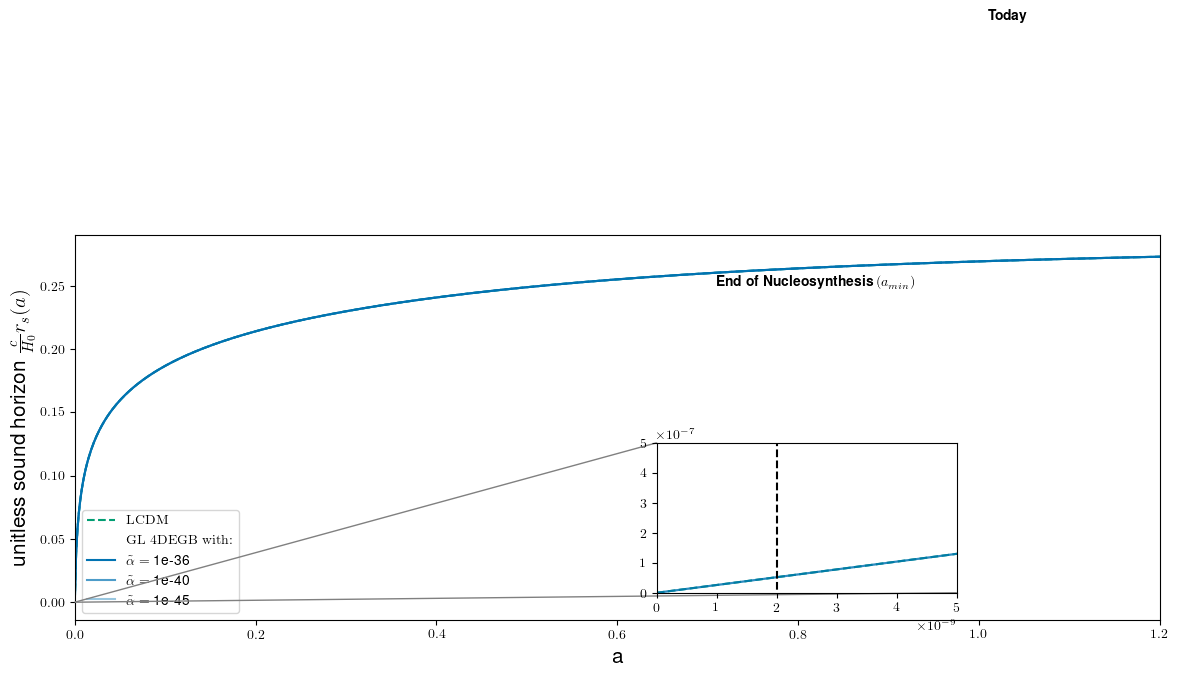

In [738]:
# Plot
fig = plt.figure(figsize=(14,5))
ax = plt.axes()

#big plot
ax.plot(a_LCDM,r_s_LCDM, label = r"$\textrm{LCDM}$", color = col[2], linestyle = "--")
ax.plot(0,0, alpha = 0, label = r"$\textrm{GL 4DEGB with:}$")
ax.plot(a,r_s1, color = col[0], alpha = 1, label = r'$\tilde{\alpha} =  $'+ " " +str(cosmo1[-2]))
ax.plot(a,r_s2, color = col[0], alpha = 0.7, label = r'$\tilde{\alpha} =  $'+ " " +str(cosmo2[-2]))
ax.plot(a,r_s3, color = col[0], alpha = 0.4, label = r'$\tilde{\alpha} =  $'+ " " +str(cosmo3[-2]))
#ax.plot(np.ones(int(1e2)), np.linspace(-1,3, int(1e2)), "k--", label = r"$\textrm{today}$")

# Make the zoom-in plot:
#axins = zoomed_inset_axes(ax, 80, loc=4) # zoom = 2
axins = inset_axes(ax, 3,1.5 , loc=4, bbox_to_anchor=(0.76, 0.15),bbox_transform=ax.figure.transFigure) # no zoom

axins.plot(a_LCDM,r_s_LCDM, label = "LCDM", color = col[2], linestyle = "--")
axins.plot(0,0, alpha = 0, label = "GL $4D$EGB with:")
#axins.plot(a,r_s1, color = col[0], alpha = 1)
axins.plot(a,r_s2, color = col[0], alpha = 0.7)
axins.plot(a,r_s3, color = col[0], alpha = 0.4)
axins.plot(2e-9*np.ones(int(1e2)), np.linspace(-1,1, int(1e2)), "k--")

axins.set_xlim(0, 5e-9)
axins.set_ylim(0, 0.5e-6)
#plt.xticks(visible=False)
#plt.yticks(visible=False)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

ax.text(1.01, 0.46, r"$\textbf{Today}$", fontfamily = "Helvetica")
axins.text(5e-9/5,1.025e-6, r"$\textbf{End of Nucleosynthesis }  (\large a_{min})$", fontfamily = "Helvetica")

ax.set_xlabel("a", size = 15)
ax.set_ylabel(r"unitless sound horizon $\frac{c}{H_0}r_s(a)$", size = 15)
#ax.set_ylim(0,0.5)
ax.set_xlim(0,1.2)
ax.legend()
plt.draw()
#plt.savefig("soundhorizon_paper.pdf")
plt.show()

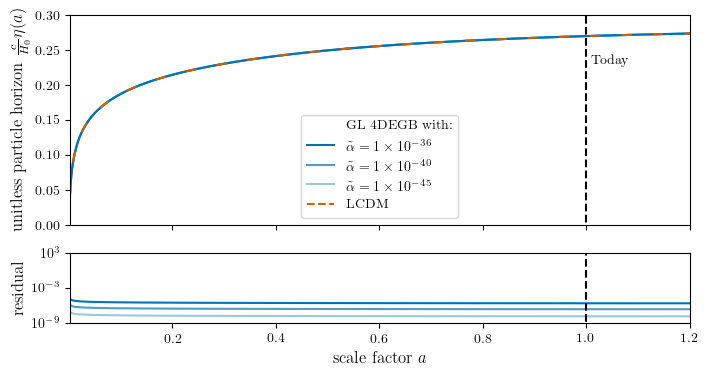

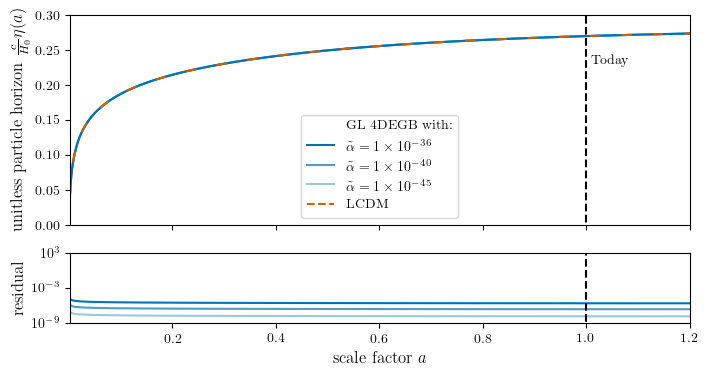

In [860]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(8,4),gridspec_kw={'height_ratios': [3,1]}, sharex=True)

#sound horizon plot
ax1.plot(0,0, alpha = 0, label = r"$\textrm{GL 4DEGB with:}$")
ax1.plot(a1,r_s1, color = col[0], alpha = 1, label = r"$\tilde{\alpha} = %.0f \times 10^{%d}$" % \
        (10**(np.log10(cosmo1[-2])-int(np.log10(cosmo1[-2])-0.1)), int(np.log10(cosmo1[-2])-0.1)))
ax1.plot(a2,r_s2, color = col[0], alpha = 0.7, label = r"$\tilde{\alpha} = %.0f \times 10^{%d}$" % \
        (10**(np.log10(cosmo2[-2])-int(np.log10(cosmo2[-2])-0.1)), int(np.log10(cosmo2[-2])-0.1)))
ax1.plot(a3,r_s3, color = col[0], alpha = 0.4, label = r"$\tilde{\alpha} = %.0f \times 10^{%d}$" % \
        (10**(np.log10(cosmo3[-2])-int(np.log10(cosmo3[-2])-0.1)), int(np.log10(cosmo3[-2])-0.1)))
ax1.plot(a1,r_s_LCDM1, color = col[3], linestyle = (0,(5,10)))
ax1.plot([0,0],[0,0], label = r"$\textrm{LCDM}$", color = col[3], linestyle = "--")

ax1.plot(np.ones(int(1e2)), np.linspace(-1,3, int(1e2)), "k--")
ax1.text(1.01, 0.23, r"$\textrm{Today}$", fontfamily = "Helvetica")
ax1.set_ylabel(r"$\textrm{unitless particle horizon }\frac{c}{H_0}\eta(a)$", size = 12)

ax1.legend()
ax1.set_ylim(0,0.3)
ax1.set_xlim(1e-3,1.2)

#relative sound horizon plot
ax2.plot(a1,r_s_LCDM1*0, label = r"$\textrm{LCDM}$", color = col[2], linestyle = "--")
ax2.plot(0,0, alpha = 0, label = r"$\textrm{GL 4DEGB with:}$")
ax2.plot(a1,(r_s1 - r_s_LCDM1)/r_s_LCDM1, color = col[0], alpha = 1, label = r"$\tilde{\alpha} = %.0f \times 10^{%d}$" % \
        (10**(np.log10(cosmo1[-2])-int(np.log10(cosmo1[-2])-0.1)), int(np.log10(cosmo1[-2])-0.1)))
ax2.plot(a2,(r_s2 - r_s_LCDM2)/r_s_LCDM2, color = col[0], alpha = 0.7, label = r"$\tilde{\alpha} = %.0f \times 10^{%d}$" % \
        (10**(np.log10(cosmo2[-2])-int(np.log10(cosmo2[-2])-0.1)), int(np.log10(cosmo2[-2])-0.1)))
ax2.plot(a3,(r_s3 - r_s_LCDM3)/r_s_LCDM3, color = col[0], alpha = 0.4, label = r"$\tilde{\alpha} = %.0f \times 10^{%d}$" % \
        (10**(np.log10(cosmo3[-2])-int(np.log10(cosmo3[-2])-0.1)), int(np.log10(cosmo3[-2])-0.1)))
ax2.plot(np.ones(int(1e2)), np.linspace(-1,1e3, int(1e2)), "k--")

ax2.set_ylabel(r"$\textrm{residual}$", size = 12)
ax2.set_xlabel(r"$\textrm{scale factor }a$", size = 12)
ax2.set_yscale("log")
ax2.set_xlim(1e-3,1.2)
ax2.set_ylim(1e-9,1e3)

plt.draw()
#plt.savefig("particlehorizon_fromplanckscale_paper.pdf")
plt.show()

In [1177]:
'''Plots of Particle Horizon'''

mp.mp.dps = 100
h = 0.67

#Find quantities
a_LCDM = np.linspace(1e-28,1.5, int(1e3))
a = np.linspace(1e-28,1.5, int(1e3))

r_s_LCDM = np.zeros(len(a))
r_s1 = np.zeros(len(a))
t_val_4DEGB = np.zeros(len(a))
t_val_LCDM = np.zeros(len(a))
cosmo1 = [0.264 , 0.0493 , 0 , Omg_rad, 1e-36, 0]

for i in range(len(a)):
    r_s_LCDM[i] = r_hor_fracH0c(1/a_LCDM[i] - 1,cosmoLCDM, 1e-28)
    r_s1[i] = r_hor_fracH0c(1/a[i] - 1 , cosmo1, 1e-28)
    t_val_4DEGB[i] = unitless_time(a[i],cosmo1)
    t_val_LCDM[i]  = unitless_time(a[i],cosmoLCDM)
    


KeyboardInterrupt: 

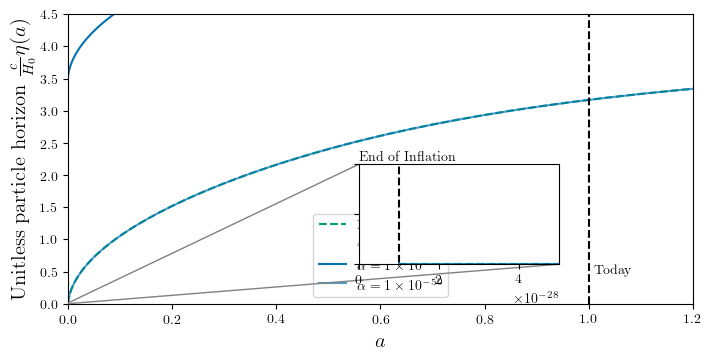

In [409]:
# Plot
fig = plt.figure(constrained_layout=True,figsize=(7,3.5))
ax = plt.axes()

#big plot
ax.plot(a_LCDM,r_s_LCDM, label = r"$\textrm{LCDM}$", color = col[2], linestyle = "--")
ax.plot(0,0, alpha = 0, label = r"$\textrm{4DEGB with:}$")
ax.plot(a,r_s1, color = col[0], alpha = 1, label = r"$\tilde{\alpha} = %.0f \times 10^{%d}$" % \
        (10**(np.log10(cosmo1[-2])-int(np.log10(cosmo1[-2])-0.1)), int(np.log10(cosmo1[-2])-0.1)))
ax.plot(a,r_s2, color = col[0], alpha = 0.7, label = r"$\tilde{\alpha} = %.0f \times 10^{%d}$" % \
        (10**(np.log10(cosmo2[-2])-int(np.log10(cosmo2[-2])-0.1)), int(np.log10(cosmo2[-2])-0.1)))
#ax.plot(a,r_s3, color = col[0], alpha = 0.4, label = r"$\tilde{\alpha} = %.0f \times 10^{%d}$" % \
#        (10**(np.log10(cosmo3[-2])-int(np.log10(cosmo3[-2])-0.1)), int(np.log10(cosmo3[-2])-0.1)))
ax.plot(np.ones(int(1e2)), np.linspace(0,4.5, int(1e2)), "k--")

# Make the zoom-in plot:
#axins = zoomed_inset_axes(ax, 80, loc=4) # zoom = 2
axins = inset_axes(ax, 2,1 , loc=4, bbox_to_anchor=(0.8,0.24), bbox_transform=ax.figure.transFigure) # no zoom

axins.plot(a_LCDM,r_s_LCDM, label = "LCDM", color = col[2], linestyle = "--")
axins.plot(0,0, alpha = 0, label = "$4D$EGB with:")
axins.plot(a,r_s1, color = col[0], alpha = 1)
axins.plot(a,r_s2, color = col[0], alpha = 0.7)
axins.plot(a,r_s3, color = col[0], alpha = 0.4)
axins.plot(1e-28*np.ones(int(1e2)), np.linspace(-1,1, int(1e2)), "k--")

axins.set_xlim(0, 5e-28)
axins.set_ylim(0, 1e-2)
#plt.xticks(visible=False)
plt.yticks(visible=False)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

ax.text(1.01, 0.46, r"$\textrm{Today}$", fontfamily = "Helvetica")
axins.text(0,1.025e-2, r"$\textrm{End of Inflation}$", fontfamily = "Helvetica")

ax.set_xlabel(r"$a$", size = 15)
ax.set_ylabel(r"$\textrm{Unitless particle horizon }\frac{c}{H_0}\eta(a)$", size = 15)
ax.set_ylim(0,4.5)
ax.set_xlim(0,1.2)
ax.legend()
plt.draw()
#plt.savefig("particlehorizon_witha_paper.pdf")
plt.show()

In [ ]:
a_new = np.logspace(-28,0, int(1e3))
r_s_LCDM_new = interpolate.make_interp_spline(a, r_s_LCDM)(a_new)
r_s1_new = interpolate.make_interp_spline(a, r_s1)(a_new)
idx_today = find_nearest_idx(a_new, 1)
idx_CMB_new = find_nearest_idx(a_new, 1/1101)
#t_4DEGB_new = interpolate.make_interp_spline(a, t_val_4DEGB)(a_new)
#t_LCDM_new = interpolate.make_interp_spline(a, t_val_LCDM)(a_new)

/tmp/ipykernel_2495851/1839516278.py:27: RuntimeWarning: overflow encountered in power
  ans = np.sqrt(Omega_m * (1 + z) ** 3 + Omega_r * (1 + z) ** 4 + Omega_k * (1 + z) ** 2 + Omega_lambda)


1.8367099231598242e-40


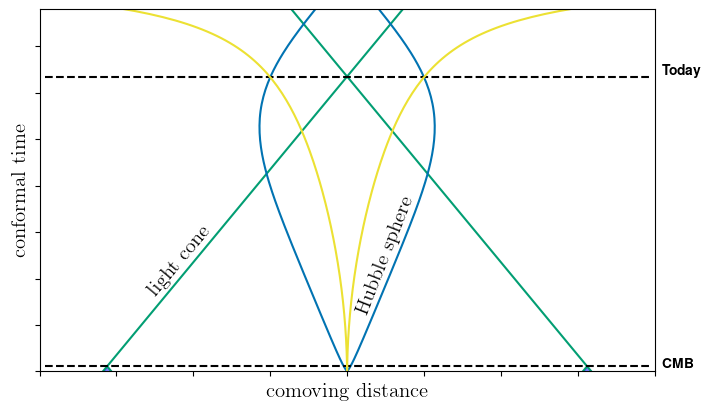

In [585]:
fig = plt.figure(constrained_layout=True,figsize=(7,4))

plt.plot(r_s_LCDM_new-r_s_LCDM_new[idx_today],r_s_LCDM_new, label = "light cone", color = col[2])
plt.plot(-r_s_LCDM_new+r_s_LCDM_new[idx_today],r_s_LCDM_new, label = "light cone", color = col[2])
plt.plot(1/(a_new*E(1/a_new - 1 , cosmoLCDM)),r_s_LCDM_new, label = "hubble sphere", color = col[0])
plt.plot(-1/(a_new*E(1/a_new - 1 , cosmoLCDM)),r_s_LCDM_new, label = "hubble sphere", color = col[0])
plt.plot(-r_s_LCDM_new[:idx_CMB]-r_s_LCDM_new[idx_today]+2*r_s_LCDM_new[idx_CMB],r_s_LCDM_new[:idx_CMB], label = "light cone", color = col[2])
plt.plot(r_s_LCDM_new[:idx_CMB]+r_s_LCDM_new[idx_today]-2*r_s_LCDM_new[idx_CMB],r_s_LCDM_new[:idx_CMB], label = "light cone", color = col[2])

plt.plot(np.linspace(-np.max(r_s_LCDM_new), np.max(r_s_LCDM_new), 100),np.ones(100)*r_s_LCDM_new[idx_today], "k--")
plt.plot(np.linspace(-np.max(r_s_LCDM_new), np.max(r_s_LCDM_new), 100),np.ones(100)*r_s_LCDM_new[idx_CMB], "k--")


#SCALE FACTOR
plt.plot((a_new),r_s_LCDM_new, label = "scale factor", color = col[8])
plt.plot((-a_new),r_s_LCDM_new, color = col[8])


plt.fill_between([r_s_LCDM_new[0]+r_s_LCDM_new[idx_today]-2*r_s_LCDM_new[idx_CMB],\
                  r_s_LCDM_new[idx_today]-r_s_LCDM_new[idx_CMB],\
                 -r_s_LCDM_new[0]+r_s_LCDM_new[idx_today]],
                [r_s_LCDM_new[0], r_s_LCDM_new[idx_CMB],0],
                [0,0,0],color="b", alpha=0.5)
plt.fill_between([-r_s_LCDM_new[0]-r_s_LCDM_new[idx_today]+2*r_s_LCDM_new[idx_CMB], \
                  -r_s_LCDM_new[idx_today]+r_s_LCDM_new[idx_CMB],\
                 r_s_LCDM_new[0]-r_s_LCDM_new[idx_today]],
                [r_s_LCDM_new[0], r_s_LCDM_new[idx_CMB],0],
                [0,0,0],color="b", alpha=0.5)

plt.text(4.1, 3.2, r"$\textbf{Today}$", fontfamily = "Helvetica", size = 10)
plt.text(4.1, 0.05, r"$\textbf{CMB}$", fontfamily = "Helvetica", size = 10)

plt.text(0.25, 0.6, r"$\textrm{Hubble sphere}$", color = 'k', rotation = 68.5,
         rotation_mode = 'anchor', size = 15)
plt.text(-2.5, 0.8, r"$\textrm{light cone}$", color = 'k', rotation = 50,
         rotation_mode = 'anchor', size = 15)


plt.xticks(visible=False)
plt.yticks(visible=False)
plt.xlim(-4,4)
plt.ylim(0,3.9)
plt.xlabel(r"$\textrm{comoving distance}$", fontfamily = "Helvetica", size = 15)
plt.ylabel(r"$\textrm{conformal time}$", fontfamily = "Helvetica", size = 15)

#plt.savefig("horizon_problem_LCDM.pdf")
plt.show()

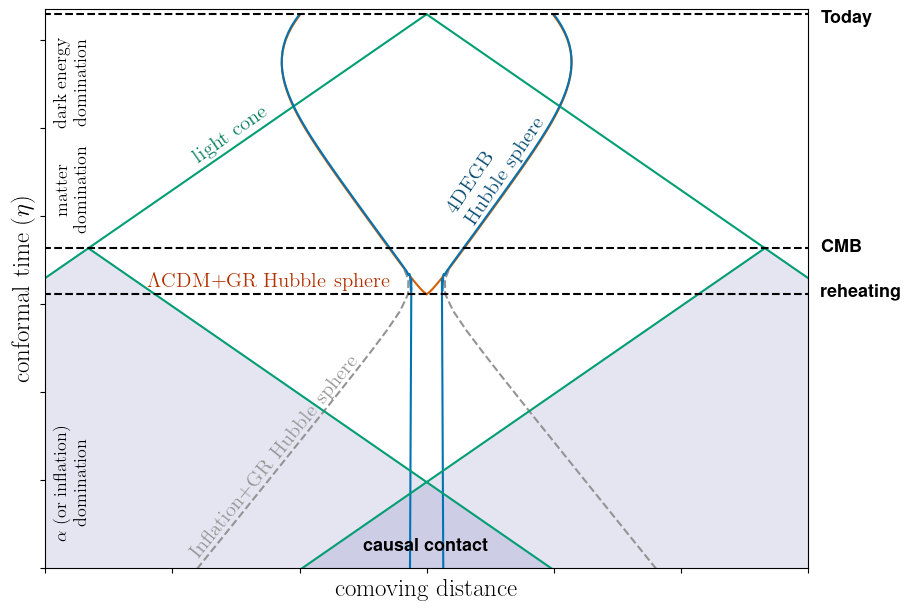

In [1176]:
'''Plots of Particle Horizon - self consistent in this cell'''

mp.mp.dps = 100
h = 0.67

#Find quantities
a_LCDM = np.linspace(1e-28,1.5, int(1e3))
a = np.linspace(1e-28,1.5, int(1e3))

r_s_LCDM = np.zeros(len(a))
r_s1 = np.zeros(len(a))
t_val_4DEGB = np.zeros(len(a))
t_val_LCDM = np.zeros(len(a))
cosmo1 = [0.264 , 0.0493 , 0 , Omg_rad, 1e-7, 0]

for i in range(len(a)):
    r_s_LCDM[i] = r_hor_fracH0c(1/a_LCDM[i] - 1,cosmoLCDM, 1e-28)
    r_s1[i] = r_hor_fracH0c(1/a[i] - 1 , cosmo1, 1e-28)
    t_val_4DEGB[i] = unitless_time(a[i],cosmo1)
    t_val_LCDM[i]  = unitless_time(a[i],cosmoLCDM)
    
a_new = np.logspace(-28,0, int(1e3))
r_s_LCDM_new = interpolate.make_interp_spline(a, r_s_LCDM)(a_new)
r_s1_new = interpolate.make_interp_spline(a, r_s1)(a_new)
idx_today = find_nearest_idx(a_new, 1)
idx_CMB_new = find_nearest_idx(a_new, 1/1101)
# Fit to alpha_C = 1e-7

fig = plt.figure(constrained_layout=True,figsize=(9,6))
ax = plt.axes()

indx_LCDM = find_nearest_idx(r_s_LCDM_new, 0)
indx_infl = 901
indx_4DEGB = 600
indx_reheating = find_nearest_idx(r_s1_new,9.11)
indx_CMB_new = 904#find_nearest_idx(r_s1_new, r_s1_new[indx_reheating]+r_s_LCDM_new[idx_CMB_new])
# LCDM
ax.plot(-1/(a_new[indx_4DEGB:]*E(1/a_new[indx_4DEGB:] - 1 , cosmoLCDM)),r_s1_new[indx_reheating]+r_s_LCDM_new[indx_4DEGB:], label = "hubble sphere", color = col[3])
ax.plot(1/(a_new[:]*E(1/a_new[:] - 1 , cosmoLCDM)),r_s1_new[indx_reheating]+r_s_LCDM_new[:], label = "hubble sphere", color = col[3])


# Inflation
ax.plot(0.56*np.sqrt(0.06+(r_s1_new[:indx_infl]-9.2)**2),r_s1_new[:indx_infl], label = "inflation", color = col[7], linestyle="--")
ax.plot(-0.56*np.sqrt(0.06+(r_s1_new[:indx_infl]-9.2)**2),r_s1_new[:indx_infl], label = "inflation", color = col[7], linestyle="--")



#4DEGB
ax.plot(r_s1_new-r_s1_new[idx_today],r_s1_new, label = "light cone", color = col[2])
ax.plot(-r_s1_new+r_s1_new[idx_today],r_s1_new, label = "light cone", color = col[2])

ax.plot(1/(a_new[indx_4DEGB:900]*E(1/a_new[indx_4DEGB:900] - 1 , cosmo1)),r_s1_new[indx_4DEGB:900], label = "hubble sphere", color = col[0])
ax.plot(1/(a_new[910:]*E(1/a_new[910:] - 1 , cosmo1)),r_s1_new[910:], label = "hubble sphere", color = col[0])
ax.plot(-1/(a_new[indx_4DEGB:900]*E(1/a_new[indx_4DEGB:900] - 1 , cosmo1)),r_s1_new[indx_4DEGB:900], label = "hubble sphere", color = col[0])
ax.plot(-1/(a_new[910:]*E(1/a_new[910:] - 1 , cosmo1)),r_s1_new[910:], label = "hubble sphere", color = col[0])

ax.plot(-r_s1_new[:indx_CMB_new]-r_s1_new[idx_today]+2*r_s1_new[indx_CMB_new],r_s1_new[:indx_CMB_new], label = "light cone", color = col[2])
ax.plot(r_s1_new[:indx_CMB_new]+r_s1_new[idx_today]-2*r_s1_new[indx_CMB_new],r_s1_new[:indx_CMB_new], label = "light cone", color = col[2])


#filled areas

ax.fill_between([r_s1_new[indx_LCDM]+r_s1_new[idx_today]-2*r_s1_new[indx_CMB_new], r_s1_new[idx_today]-r_s1_new[indx_CMB_new],\
                 -r_s1_new[indx_LCDM]+r_s1_new[idx_today]],
                [r_s1_new[indx_LCDM],r_s1_new[indx_CMB_new],r_s1_new[indx_LCDM]],
                [r_s1_new[indx_LCDM],r_s1_new[indx_LCDM],r_s1_new[indx_LCDM]],color=lighten_color("b", 1.5), alpha=0.1)
ax.fill_between([-r_s1_new[indx_LCDM]-r_s1_new[idx_today]+2*r_s1_new[indx_CMB_new],-r_s1_new[idx_today]+r_s1_new[indx_CMB_new],\
                 r_s1_new[indx_LCDM]-r_s1_new[idx_today]],
                [r_s1_new[indx_LCDM],r_s1_new[indx_CMB_new],r_s1_new[indx_LCDM]],
                [r_s1_new[indx_LCDM],r_s1_new[indx_LCDM],r_s1_new[indx_LCDM]],color=lighten_color("b", 1.5), alpha=0.1)

# Times
ax.plot(np.linspace(-np.max(r_s1_new), np.max(r_s1_new), 100),np.ones(100)*r_s1_new[idx_today], "k--")
ax.plot(np.linspace(-np.max(r_s1_new), np.max(r_s1_new), 100),np.ones(100)*(r_s1_new[indx_CMB_new]), "k--")
ax.plot(np.linspace(-np.max(r_s1_new), np.max(r_s1_new), 100),np.ones(100)*r_s1_new[indx_reheating], "k--")

#Text
ax.text(3.1, 12.2, r"$\textbf{Today}$", fontfamily = "Helvetica", size = 13)
ax.text(3.1, 9.6, r"$\textbf{CMB}$", fontfamily = "Helvetica", size = 13)
ax.text(3.1, 9.08, r"$\textbf{reheating}$", fontfamily = "Helvetica", size = 13)
ax.text(-0.5,6.2, r"$\textbf{causal contact}$", fontfamily = "Helvetica", size = 13)


ax.text(0.35, 9.9, r"$\textrm{4DEGB}$" "\n" r"$\textrm{Hubble sphere}$", color = lighten_color(col[0], 1.2), rotation = 56,
         rotation_mode = 'anchor', size = 15)
ax.text(-1.8, 10.6, r"$\textrm{light cone}$", color = lighten_color(col[2], 1.1), rotation = 35,
         rotation_mode = 'anchor', size = 15)

ax.text(-1.8, 6.1, r"$\textrm{Inflation+GR Hubble sphere}$", color = col[7], rotation = 51.0,
         rotation_mode = 'anchor', size = 15)

ax.text(-2.7, 11.0, r"$\textrm{dark energy}$" "\n" r"$\textrm{domination}$", color = 'k', rotation = 90,
         rotation_mode = 'anchor', size = 13,multialignment='center')
ax.text(-2.7, 9.8, r"$\textrm{matter}$" "\n" r"$\textrm{domination}$", color = 'k', rotation = 90,
         rotation_mode = 'anchor', size = 13, multialignment='center')
ax.text(-2.7, 6.3, r"$\alpha\textrm{ (or inflation)}$" "\n" r"$\textrm{domination}$", color = 'k', rotation = 90,
         rotation_mode = 'anchor', size = 13,multialignment='center')
ax.text(-2.2,9.2,r"$\Lambda\textrm{CDM+GR Hubble sphere}$", color = lighten_color("coral",1.9), size = 15)

plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)

plt.xlabel(r"$\textrm{comoving distance}$", fontfamily = "Helvetica", size = 18)
plt.ylabel(r"$\textrm{conformal time }(\eta)$", fontfamily = "Helvetica", size = 18)

#ax.plot((a_new[9700:]),r_s1_new[9700:], label = "scale factor", color = col[8])
ax.set_xlim(-3.0,3.0)
ax.set_ylim(6,12.35)
#plt.savefig("horizon_problem_infl_4DEGB.pdf")
plt.show()

In [ ]:
# Check horizon problem solution if cutoff scale is planck scale
fig = plt.figure(constrained_layout=True,figsize=(7,6))
ax = plt.axes()

#indx_CMB_new = 0
a_planck1_new = a_planck1
r_planckhor1 = r_hor_fracH0c(1/a_planck1_new - 1, cosmo1, a_planck1_new)
#plt.plot(r_planckhor1*np.ones(len(r_s1_new)),r_s1_new)

#4DEGB
#ax.plot(r_s1_new-r_s1_new[idx_today],r_s1_new, label = "light cone", color = col[2])
#ax.plot(-r_s1_new+r_s1_new[idx_today],r_s1_new, label = "light cone", color = col[2])
ax.plot(1/(a_new[:]*E(1/a_new[:] - 1 , cosmo1)),r_s1_new[:], label = "hubble sphere", color = col[0])
ax.plot(-1/(a_new[:]*E(1/a_new[:] - 1 , cosmo1)),r_s1_new[:], label = "hubble sphere", color = col[0])
#ax.plot(-r_s1_new[:indx_CMB_new]-r_s1_new[idx_today]+2*r_s1_new[indx_CMB_new],r_s1_new[:indx_CMB_new], label = "light cone", color = col[2])
#ax.plot(r_s1_new[:indx_CMB_new]+r_s1_new[idx_today]-2*r_s1_new[indx_CMB_new],r_s1_new[:indx_CMB_new], label = "light cone", color = col[2])

#filled areas
"""
ax.fill_between([r_s1_new[indx_LCDM]+r_s1_new[idx_today]-2*r_s1_new[indx_CMB_new], r_s1_new[idx_today]-r_s1_new[indx_CMB_new],\
                 -r_s1_new[indx_LCDM]+r_s1_new[idx_today]],
                [r_s1_new[indx_LCDM],r_s1_new[indx_CMB_new],r_s1_new[indx_LCDM]],
                [r_s1_new[indx_LCDM],r_s1_new[indx_LCDM],r_s1_new[indx_LCDM]],color=lighten_color("b", 1.5), alpha=0.1)
ax.fill_between([-r_s1_new[indx_LCDM]-r_s1_new[idx_today]+2*r_s1_new[indx_CMB_new],-r_s1_new[idx_today]+r_s1_new[indx_CMB_new],\
                 r_s1_new[indx_LCDM]-r_s1_new[idx_today]],
                [r_s1_new[indx_LCDM],r_s1_new[indx_CMB_new],r_s1_new[indx_LCDM]],
                [r_s1_new[indx_LCDM],r_s1_new[indx_LCDM],r_s1_new[indx_LCDM]],color=lighten_color("b", 1.5), alpha=0.1)

"""
# Times
#ax.plot(np.linspace(-np.max(r_s1_new), np.max(r_s1_new), 100),np.ones(100)*r_s1_new[idx_today], "k--")
#ax.plot(np.linspace(-np.max(r_s1_new), np.max(r_s1_new), 100),np.ones(100)*(r_s1_new[indx_CMB_new]), "k--")
#ax.plot(np.linspace(-np.max(r_s1_new), np.max(r_s1_new), 100),np.ones(100)*r_s1_new[indx_reheating], "k--")

plt.show()

450 450


/tmp/ipykernel_2495851/1839516278.py:27: RuntimeWarning: overflow encountered in power
  ans = np.sqrt(Omega_m * (1 + z) ** 3 + Omega_r * (1 + z) ** 4 + Omega_k * (1 + z) ** 2 + Omega_lambda)


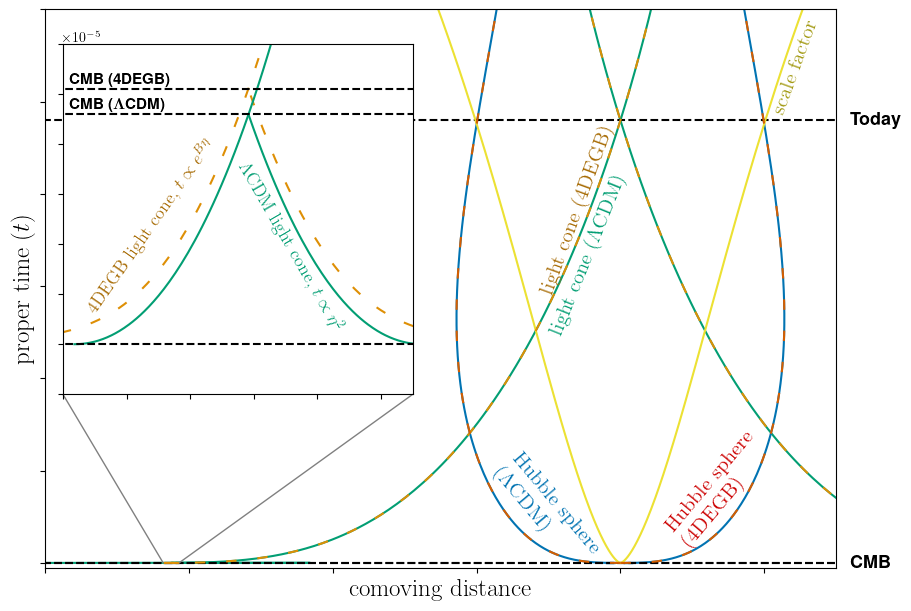

In [733]:
# Fits best for alpha_C = 1e-11

fig = plt.figure(constrained_layout=True,figsize=(9,6))
ax = plt.axes()

# LCDM
#x.plot(-1/(a_new[2500:]*E(1/a_new[2500:] - 1 , cosmoLCDM)),r_s1_new[2500:], label = "hubble sphere", color = col[0])
#x.plot(1/(a_new[2500:]*E(1/a_new[2500:] - 1 , cosmoLCDM)),r_s1_new[2500:], label = "hubble sphere", color = col[0])

#4DEGB
ax.plot(0,0, alpha = 0, label = r"$4D$EGB")
ax.plot(r_s1_new-r_s1_new[idx_today],t_4DEGB_new, label = "past light cone", color = col[2])
ax.plot(-r_s1_new+r_s1_new[idx_today],t_4DEGB_new, color = col[2])
ax.plot(1/(a_new[5500:]*E(1/a_new[5500:] - 1 , cosmo1)),t_4DEGB_new[5500:], label = "hubble sphere", color = col[0])
ax.plot(-1/(a_new[5500:]*E(1/a_new[5500:] - 1 , cosmo1)),t_4DEGB_new[5500:], color = col[0])
ax.plot(-r_s1_new[:idx_CMB+1]-r_s1_new[idx_today]+2*r_s1_new[idx_CMB],t_4DEGB_new[:idx_CMB+1], color = col[2])
ax.plot(r_s1_new[:idx_CMB+1]+r_s1_new[idx_today]-2*r_s1_new[idx_CMB],t_4DEGB_new[:idx_CMB+1], color = col[2])

# Dotted continuation lines
print(len(a[550:1000]),len(r_s1[100:550]))
ax.plot(-0.02 -1/(a[550:900]*E(1/a[550:900] - 1 , cosmo1)),t_4DEGB_new[200:550], color = col[0], linestyle=":",linewidth=1.0, dashes=(7, 3)) 
ax.plot(1/(a[550:900]*E(1/a[550:900] - 1 , cosmo1)),t_4DEGB_new[200:550], color = col[0], linestyle=":", linewidth=1.0, dashes=(7, 3)) 


ax.plot(r_s1_new[9580:idx_CMB]+r_s1_new[idx_today]-2*r_s1_new[idx_CMB],t_4DEGB_new[9580:idx_CMB], color = col[0])

# Times

ax.plot(np.linspace(-np.max(r_s1_new), np.max(r_s1_new), 100),np.ones(100)*t_4DEGB_new[idx_today], "k--")
ax.plot(np.linspace(-np.max(r_s1_new), np.max(r_s1_new), 100),np.ones(100)*t_4DEGB_new[idx_CMB], "k--")
ax.plot(np.linspace(-np.max(r_s1_new), np.max(r_s1_new), 100),np.ones(100)*t_4DEGB_new[9580], "k--")

#SCALE FACTOR
ax.plot((a_new[1000:]),t_4DEGB_new[1000:], label = "scale factor", color = col[8])
ax.plot((-a_new[1000:]),t_4DEGB_new[1000:],color = col[8])

## LCDM ##
ax.plot(0,0, alpha = 0, label = r"$\Lambda$CDM")
ax.plot(r_s_LCDM_new-r_s_LCDM_new[idx_today],t_LCDM_new, color=lighten_color(col[1],1.0),linestyle=(0,(5,10)), label = "past light cone")
ax.plot(-r_s_LCDM_new+r_s_LCDM_new[idx_today],t_LCDM_new, color=lighten_color(col[1],1.0),linestyle=(0,(5,10)))
ax.plot(1/(a_new*E(1/a_new - 1 , cosmoLCDM)),t_LCDM_new, color=lighten_color(col[3],1.0),linestyle=(0,(5,10)), label = "hubble sphere")
ax.plot(-1/(a_new*E(1/a_new - 1 , cosmoLCDM)),t_LCDM_new, color=lighten_color(col[3],1.0),linestyle=(0,(5,10)))
ax.plot(-r_s_LCDM_new[:idx_CMB+1]-r_s_LCDM_new[idx_today]+2*r_s_LCDM_new[idx_CMB],t_LCDM_new[:idx_CMB+1],color=lighten_color(col[1],1.0),linestyle=(0,(5,10)))
ax.plot(r_s_LCDM_new[:idx_CMB+1]+r_s_LCDM_new[idx_today]-2*r_s_LCDM_new[idx_CMB],t_LCDM_new[:idx_CMB+1], color=lighten_color(col[1],1.0),linestyle=(0,(5,10)))

#SCALE FACTOR
#ax.plot((a_new[1000:]),t_LCDM_new[1000:], color=lighten_color(col[8],1.5),linestyle=(0,(5,10)), label = "scale factor")
#ax.plot((-a_new[1000:]),t_LCDM_new[1000:], color=lighten_color(col[8],1.5),linestyle=(0,(5,10)))
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.xlabel(r"$\textrm{comoving distance }$", fontfamily = "Helvetica", size = 18)
plt.ylabel(r"$\textrm{proper time } (t)$", fontfamily = "Helvetica", size = 18)

# Zoomed in bit

axins = inset_axes(ax, 3.5,3.5 , loc=4, bbox_to_anchor=(0.46,0.34), bbox_transform=ax.figure.transFigure) # no zoom

## 4DEGB ##
axins.plot(-r_s1_new[:idx_CMB+1]-r_s1_new[idx_today]+2*r_s1_new[idx_CMB],t_4DEGB_new[:idx_CMB+1], color = col[1],linestyle=(0,(5,10)))
axins.plot(r_s1_new-r_s1_new[idx_today],t_4DEGB_new, color = col[1],linestyle=(0,(5,10)))
#axins.scatter(r_s1_new[0]-r_s1_new[idx_today],t_4DEGB_new[0], color = col[2])

## LCDM ##
axins.plot(r_s_LCDM_new-r_s_LCDM_new[idx_today],t_LCDM_new, color=lighten_color(col[2],1.0))
axins.plot(-r_s_LCDM_new[:idx_CMB+1]-r_s_LCDM_new[idx_today]+2*r_s_LCDM_new[idx_CMB],t_LCDM_new[:idx_CMB+1],color=lighten_color(col[2],1.0))
axins.plot(np.linspace(-np.max(r_s1_new), np.max(r_s1_new), 100),np.zeros(100), "k--")
axins.plot(np.linspace(-np.max(r_s1_new), np.max(r_s1_new), 100),np.ones(100)*t_4DEGB_new[idx_CMB], "k--")
axins.plot(np.linspace(-np.max(r_s1_new), np.max(r_s1_new), 100),np.ones(100)*t_LCDM_new[idx_CMB], "k--")

axins.set_xlim(-3.18, -3.07)
axins.set_ylim(-5e-6, 3e-5)
mark_inset(ax, axins, loc1=4, loc2=3, fc="none", ec="0.5")

## TEXT ##
ax.text(-0.48, 0.58, r"$\textrm{light cone (4DEGB)}$", color=lighten_color(col[1],1.2), rotation = 70,
         rotation_mode = 'anchor', size = 15)
ax.text(-0.42, 0.49, r"$\textrm{light cone }(\Lambda \textrm{CDM})$", color = col[2], rotation = 68,
         rotation_mode = 'anchor', size = 15)
ax.text(0.47, 0.038, r"$\textrm{Hubble sphere}$""\n"r"$\textrm{(4DEGB)}$", color = lighten_color("r",1.2), rotation = 50,
         rotation_mode = 'anchor', size = 15)
ax.text(-0.86, 0.2, r"$\textrm{Hubble sphere}$""\n"r"$(\Lambda \textrm{CDM})$", color = col[0], rotation = 310,
         rotation_mode = 'anchor', size = 15)
ax.text(1.6, 0.95, r"$\textbf{Today}$", fontfamily = "Helvetica", size = 13)
ax.text(1.6, -0.01, r"$\textbf{CMB}$", fontfamily = "Helvetica", size = 13)
ax.text(1.13, 0.97, r"$\textrm{scale factor}$", color = lighten_color(col[8], 1.5), rotation = 70,
         rotation_mode = 'anchor', size = 15)

axins.text(-3.125, 1.785e-5, r"$\Lambda\textrm{CDM light cone, }t \propto \eta^2$", color = lighten_color(col[2],1.0), rotation = 300,
         rotation_mode = 'anchor', size = 13)
axins.text(-3.17, 3e-6, r"$\textrm{4DEGB light cone, }t \propto e^{B\eta}$", color =lighten_color(col[1],1.2), rotation = 55,
         rotation_mode = 'anchor', size = 13)
axins.text(-3.178, 2.35e-5, r"$\textbf{CMB (}\mathbf{\Lambda}\textbf{CDM)}$", fontfamily = "Helvetica", size = 11)
axins.text(-3.178, 2.6e-5, r"$\textbf{CMB (4DEGB)}$", fontfamily = "Helvetica", size = 11)

ax.set_xlim(-4,1.5)
ax.set_ylim(-0.01,1.2)
#ax.set_xscale("log")
plt.xticks(visible=False)
plt.yticks(visible=False)
#ax.legend(loc=7)
#plt.savefig("horizon_problem_infl_propertime.pdf")

plt.show()

/tmp/ipykernel_2495851/1839516278.py:17: RuntimeWarning: overflow encountered in power
  return 1 + 4 * alpha_tilde * (Omega_m * (1 + z) ** 3 + (Omega_r + alpha_tilde*C_t**2) * (1 + z)** 4 + Omega_lambda)
/tmp/ipykernel_2495851/1839516278.py:27: RuntimeWarning: overflow encountered in power
  ans = np.sqrt(Omega_m * (1 + z) ** 3 + Omega_r * (1 + z) ** 4 + Omega_k * (1 + z) ** 2 + Omega_lambda)


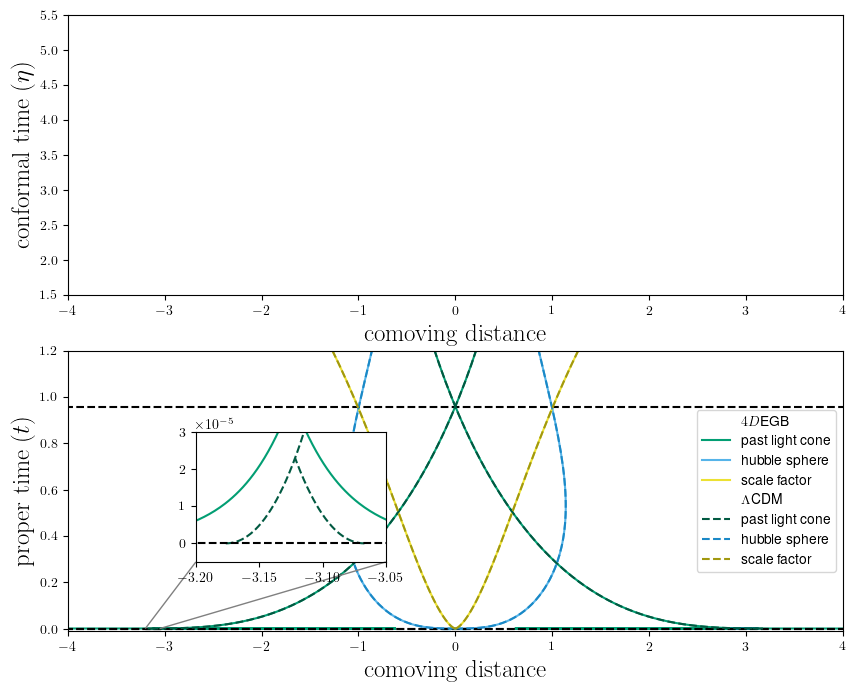

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(10,8))

indx_LCDM = 9000
indx_infl = 9540
indx_4DEGB = 1000
# LCDM
ax1.plot(-1/(a_new[indx_LCDM:]*E(1/a_new[indx_LCDM:] - 1 , cosmoLCDM)),r_s1_new[indx_LCDM:], label = "hubble sphere", color = col[0])
ax1.plot(1/(a_new[indx_LCDM:]*E(1/a_new[indx_LCDM:] - 1 , cosmoLCDM)),r_s1_new[indx_LCDM:], label = "hubble sphere", color = col[0])

# Inflation
ax1.plot(0.5*np.sqrt(0.06+(r_s1_new[:indx_infl]-19.6)**2),r_s1_new[:indx_infl], label = "inflation", color = col[1], linestyle="--")
ax1.plot(-0.5*np.sqrt(0.06+(r_s1_new[:indx_infl]-19.6)**2),r_s1_new[:indx_infl], label = "inflation", color = col[1], linestyle="--")

#SCALE FACTOR
ax1.plot((a_new),r_s1_new, label = "scale factor", color = col[8])
ax1.plot((-a_new),r_s1_new, color = col[8])

"""
# Inflation
ax.plot(0.5*np.sqrt(0.1+(r_s1_new[:9840]-4.4)**2),r_s1_new[:9840], label = "inflation", color = col[1], linestyle="--")
ax.plot(-0.5*np.sqrt(0.1+(r_s1_new[:9840]-4.4)**2),r_s1_new[:9840], label = "inflation", color = col[1], linestyle="--")
"""
#4DEGB
ax1.plot(r_s1_new-r_s1_new[idx_today],r_s1_new, label = "light cone", color = col[2])
ax1.plot(-r_s1_new+r_s1_new[idx_today],r_s1_new, label = "light cone", color = col[2])
ax1.plot(1/(a_new[indx_4DEGB:]*E(1/a_new[indx_4DEGB:] - 1 , cosmo1)),r_s1_new[indx_4DEGB:], label = "hubble sphere", color = col[9])
ax1.plot(-1/(a_new[indx_4DEGB:]*E(1/a_new[indx_4DEGB:] - 1 , cosmo1)),r_s1_new[indx_4DEGB:], label = "hubble sphere", color = col[9])
ax1.plot(-r_s1_new[:idx_CMB]-r_s1_new[idx_today]+2*r_s1_new[idx_CMB],r_s1_new[:idx_CMB], label = "light cone", color = col[2])
ax1.plot(r_s1_new[:idx_CMB]+r_s1_new[idx_today]-2*r_s1_new[idx_CMB],r_s1_new[:idx_CMB], label = "light cone", color = col[2])

#filled areas
"""
ax.fill_between([r_s1_new[indx_LCDM]+r_s1_new[idx_today]-2*r_s1_new[idx_CMB], r_s1_new[idx_today]-r_s1_new[idx_CMB],\
                 -r_s1_new[indx_LCDM]+r_s1_new[idx_today]],
                [r_s1_new[indx_LCDM],r_s1_new[idx_CMB],r_s1_new[indx_LCDM]],
                [r_s1_new[indx_LCDM],r_s1_new[indx_LCDM],r_s1_new[indx_LCDM]],color="b", alpha=0.5)
ax.fill_between([-r_s1_new[indx_LCDM]-r_s1_new[idx_today]+2*r_s1_new[idx_CMB],-r_s1_new[idx_today]+r_s1_new[idx_CMB],\
                 r_s1_new[indx_LCDM]-r_s1_new[idx_today]],
                [r_s1_new[indx_LCDM],r_s1_new[idx_CMB],r_s1_new[indx_LCDM]],
                [r_s1_new[indx_LCDM],r_s1_new[indx_LCDM],r_s1_new[indx_LCDM]],color="b", alpha=0.5)
"""
# Times
ax1.plot(np.linspace(-np.max(r_s1_new), np.max(r_s1_new), 100),np.ones(100)*r_s1_new[idx_today], "k--")
ax1.plot(np.linspace(-np.max(r_s1_new), np.max(r_s1_new), 100),np.ones(100)*r_s1_new[idx_CMB], "k--")
#ax.plot(np.linspace(-np.max(r_s1_new), np.max(r_s1_new), 100),np.ones(100)*r_s1_new[indx_LCDM], "k--")
"""
#Text
ax.text(4.1, 22.7, r"$\textbf{Today}$", fontfamily = "Helvetica", size = 13)
ax.text(4.1, 19.6, r"$\textbf{CMB}$", fontfamily = "Helvetica", size = 13)
ax.text(4.1, 19.3, r"$\textbf{reheating}$", fontfamily = "Helvetica", size = 13)
ax.text(-0.97,15.3, r"$\textbf{causal contact}$", fontfamily = "Helvetica", size = 13)


ax.text(0.09, 19.8, r"$\textrm{Hubble sphere}$", color = 'k', rotation = 64.5,
         rotation_mode = 'anchor', size = 15)
ax.text(-2.5, 20.39, r"$\textrm{light cone}$", color = 'k', rotation = 45.5,
         rotation_mode = 'anchor', size = 15)

ax.text(-2.2, 15.4, r"$\textrm{inflation}$", color = col[1], rotation = 62,
         rotation_mode = 'anchor', size = 15)

ax.text(-3.5, 22.1, r"$\textrm{dark energy}$" "\n" r"$\textrm{domination}$", color = 'k', rotation = 90,
         rotation_mode = 'anchor', size = 13,multialignment='center')
ax.text(-3.5, 20.2, r"$\textrm{radiation}$" "\n" r"$\textrm{domination}$", color = 'k', rotation = 90,
         rotation_mode = 'anchor', size = 13, multialignment='center')
ax.text(-3.5, 16.6, r"$\alpha\textrm{ (or inflation)}$" "\n" r"$\textrm{domination}$", color = 'k', rotation = 90,
         rotation_mode = 'anchor', size = 13,multialignment='center')
"""
plt.setp(ax1.get_xticklabels(), visible=True)
plt.setp(ax1.get_yticklabels(), visible=True)

ax1.set_xlabel(r"$\textrm{comoving distance}$", fontfamily = "Helvetica", size = 18)
ax1.set_ylabel(r"$\textrm{conformal time }(\eta)$", fontfamily = "Helvetica", size = 18)

#ax.plot((a_new[9700:]),r_s1_new[9700:], label = "scale factor", color = col[8])
ax1.set_xlim(-4,4)
ax1.set_ylim(1.5,5.5)
#ax.set_xlim(-4,4)
#ax.set_ylim(15,23.5)

########### Second plot

#4DEGB
ax2.plot(0,0, alpha = 0, label = r"$4D$EGB")
ax2.plot(r_s1_new-r_s1_new[idx_today],t_4DEGB_new, label = "past light cone", color = col[2])
ax2.plot(-r_s1_new+r_s1_new[idx_today],t_4DEGB_new, color = col[2])
ax2.plot(1/(a_new[5500:]*E(1/a_new[5500:] - 1 , cosmo1)),t_4DEGB_new[5500:], label = "hubble sphere", color = col[9])
ax2.plot(-1/(a_new[5500:]*E(1/a_new[5500:] - 1 , cosmo1)),t_4DEGB_new[5500:], color = col[9])
ax2.plot(-r_s1_new[:idx_CMB+1]-r_s1_new[idx_today]+2*r_s1_new[idx_CMB],t_4DEGB_new[:idx_CMB+1], color = col[2])
ax2.plot(r_s1_new[:idx_CMB+1]+r_s1_new[idx_today]-2*r_s1_new[idx_CMB],t_4DEGB_new[:idx_CMB+1], color = col[2])

# Dotted continuation lines
ax2.plot(-0.02 -1/(a[550:900]*E(1/a[550:900] - 1 , cosmo1)),t_4DEGB_new[200:550], color = col[9], linestyle=":",linewidth=1.0, dashes=(7, 3)) 
ax2.plot(1/(a[550:900]*E(1/a[550:900] - 1 , cosmo1)),t_4DEGB_new[200:550], color = col[9], linestyle=":", linewidth=1.0, dashes=(7, 3)) 


ax2.plot(r_s1_new[9580:idx_CMB]+r_s1_new[idx_today]-2*r_s1_new[idx_CMB],t_4DEGB_new[9580:idx_CMB], color = col[0])

# Times

ax2.plot(np.linspace(-np.max(r_s1_new), np.max(r_s1_new), 100),np.ones(100)*t_4DEGB_new[idx_today], "k--")
ax2.plot(np.linspace(-np.max(r_s1_new), np.max(r_s1_new), 100),np.ones(100)*t_4DEGB_new[idx_CMB], "k--")
ax2.plot(np.linspace(-np.max(r_s1_new), np.max(r_s1_new), 100),np.ones(100)*t_4DEGB_new[9580], "k--")

#SCALE FACTOR
ax2.plot((a_new[1000:]),t_4DEGB_new[1000:], label = "scale factor", color = col[8])
ax2.plot((-a_new[1000:]),t_4DEGB_new[1000:],color = col[8])

## LCDM ##
ax2.plot(0,0, alpha = 0, label = r"$\Lambda$CDM")
ax2.plot(r_s_LCDM_new-r_s_LCDM_new[idx_today],t_LCDM_new, color=lighten_color(col[2],1.2),linestyle="--", label = "past light cone")
ax2.plot(-r_s_LCDM_new+r_s_LCDM_new[idx_today],t_LCDM_new, color=lighten_color(col[2],1.2),linestyle="--")
ax2.plot(1/(a_new*E(1/a_new - 1 , cosmoLCDM)),t_LCDM_new, color=lighten_color(col[9],1.5),linestyle="--", label = "hubble sphere")
ax2.plot(-1/(a_new*E(1/a_new - 1 , cosmoLCDM)),t_LCDM_new, color=lighten_color(col[9],1.5),linestyle="--")
ax2.plot(-r_s_LCDM_new[:idx_CMB+1]-r_s_LCDM_new[idx_today]+2*r_s_LCDM_new[idx_CMB],t_LCDM_new[:idx_CMB+1],color=lighten_color(col[2],1.2),linestyle="--")
ax2.plot(r_s_LCDM_new[:idx_CMB+1]+r_s_LCDM_new[idx_today]-2*r_s_LCDM_new[idx_CMB],t_LCDM_new[:idx_CMB+1], color=lighten_color(col[2],1.2),linestyle="--")

#SCALE FACTOR
ax2.plot((a_new[1000:]),t_LCDM_new[1000:], color=lighten_color(col[8],1.5),linestyle="--", label = "scale factor")
ax2.plot((-a_new[1000:]),t_LCDM_new[1000:], color=lighten_color(col[8],1.5),linestyle="--")

# Zoomed in bit

axins = inset_axes(ax2, 1.9,1.3 , loc=4, bbox_to_anchor=(0.5,0.25), bbox_transform=ax.figure.transFigure) # no zoom

## 4DEGB ##
axins.plot(-r_s1_new[:idx_CMB+1]-r_s1_new[idx_today]+2*r_s1_new[idx_CMB],t_4DEGB_new[:idx_CMB+1], color = col[2])
axins.plot(r_s1_new-r_s1_new[idx_today],t_4DEGB_new, color = col[2])
## LCDM ##
axins.plot(r_s_LCDM_new-r_s_LCDM_new[idx_today],t_LCDM_new, color=lighten_color(col[2],1.2),linestyle="--")
axins.plot(-r_s_LCDM_new[:idx_CMB+1]-r_s_LCDM_new[idx_today]+2*r_s_LCDM_new[idx_CMB],t_LCDM_new[:idx_CMB+1],color=lighten_color(col[2],1.2),linestyle="--")
axins.plot(np.linspace(-np.max(r_s1_new), np.max(r_s1_new), 100),np.zeros(100), "k--")
axins.plot(np.linspace(-np.max(r_s1_new), np.max(r_s1_new), 100),np.ones(100)*t_4DEGB_new[idx_CMB], "k--")

axins.set_xlim(-3.2, -3.05)
axins.set_ylim(-5e-6, 3e-5)
mark_inset(ax2, axins, loc1=4, loc2=3, fc="none", ec="0.5")


ax2.set_xlabel(r"$\textrm{comoving distance}$", fontfamily = "Helvetica", size = 18)
ax2.set_ylabel(r"$\textrm{proper time } (t)$", fontfamily = "Helvetica", size = 18)

ax2.set_xlim(-4,4)
ax2.set_ylim(-0.01,1.2)
#ax.set_xscale("log")
#plt.xticks(visible=False)
#plt.yticks(visible=False)fig, (ax1, ax2) = plt.subplots(1, 2)
ax2.legend(loc=7)
#plt.savefig("horizon_problem_comparingtimes.pdf", bbox_inches='tight')

plt.show()

In [ ]:

"""
# Dotted continuation lines
print(len(a[550:1000]),len(r_s1[100:550]))
ax.plot(-0.02 -1/(a[550:900]*E(1/a[550:900] - 1 , cosmo1)),r_s1[200:550], color = col[9], linestyle=":",linewidth=1.0, dashes=(7, 3)) 
ax.plot(1/(a[550:900]*E(1/a[550:900] - 1 , cosmo1)),r_s1[200:550], color = col[9], linestyle=":", linewidth=1.0, dashes=(7, 3)) 

#filled areas
ax.fill_between([r_s1_new[9580]+r_s1_new[idx_today]-2*r_s1_new[idx_CMB], r_s1_new[idx_today]-r_s1_new[idx_CMB],\
                 -r_s1_new[9580]+r_s1_new[idx_today]],
                [r_s1_new[9580],r_s1_new[idx_CMB],r_s1_new[9580]],
                [r_s1_new[9580],r_s1_new[9580],r_s1_new[9580]],color="b", alpha=0.5)
ax.fill_between([-r_s1_new[9580]-r_s1_new[idx_today]+2*r_s1_new[idx_CMB],-r_s1_new[idx_today]+r_s1_new[idx_CMB],\
                 r_s1_new[9580]-r_s1_new[idx_today]],
                [r_s1_new[9580],r_s1_new[idx_CMB],r_s1_new[9580]],
                [r_s1_new[9580],r_s1_new[9580],r_s1_new[9580]],color="b", alpha=0.5)
ax.fill_between([r_s1_new[0]+r_s1_new[idx_today]-2*r_s1_new[idx_CMB],0,\
               -r_s1_new[0]-r_s1_new[idx_today]+2*r_s1_new[idx_CMB]],
                [0,r_s1_new[find_nearest_idx(r_s1_new[:idx_CMB]+r_s1_new[idx_today]-2*r_s1_new[idx_CMB],0)],0],
                [0,0,0],color="b", alpha=0.5)


ax.plot(r_s1_new[9580:idx_CMB]+r_s1_new[idx_today]-2*r_s1_new[idx_CMB],r_s1_new[9580:idx_CMB], label = "light cone", color = col[0])

# Times
ax.plot(np.linspace(-np.max(r_s1_new), np.max(r_s1_new), 100),np.ones(100)*r_s1_new[idx_today], "k--")
ax.plot(np.linspace(-np.max(r_s1_new), np.max(r_s1_new), 100),np.ones(100)*r_s1_new[idx_CMB], "k--")
ax.plot(np.linspace(-np.max(r_s1_new), np.max(r_s1_new), 100),np.ones(100)*r_s1_new[9580], "k--")


# Zoomed in bit
axins = inset_axes(ax, 2.2,1.2 , loc=4, bbox_to_anchor=(0.85,0.085), bbox_transform=ax.figure.transFigure) # no zoom

axins.plot(-1/(a_new[9580:]*E(1/a_new[9580:] - 1 , cosmoLCDM)),r_s1_new[9580:], label = "hubble sphere", color = col[0])
axins.plot(1/(a_new[9580:]*E(1/a_new[9580:] - 1 , cosmoLCDM)),r_s1_new[9580:], label = "hubble sphere", color = col[0])
axins.plot(1/(a_new*E(1/a_new - 1 , cosmo1)),r_s1_new, label = "hubble sphere", color = col[9])
axins.plot(-1/(a_new*E(1/a_new - 1 , cosmo1)),r_s1_new, label = "hubble sphere", color = col[9])
axins.plot(np.linspace(-np.max(r_s1_new), np.max(r_s1_new), 100),np.ones(100)*r_s1_new[9580], "k--")

#Text
ax.text(4.1, 7.5, r"$\textbf{Today}$", fontfamily = "Helvetica")
ax.text(4.1, 4.4, r"$\textbf{CMB}$", fontfamily = "Helvetica")
ax.text(4.1, 4.1, r"$\textbf{Big Bang in }\Lambda\textbf{CDM}$", fontfamily = "Helvetica")
ax.text(-0.7,0.3, r"$\textbf{causal contact}$", fontfamily = "Helvetica")


ax.text(0.1, 4.6, r"$\textrm{Hubble sphere}$", color = 'k', rotation = 64,
         rotation_mode = 'anchor', size = 15)
ax.text(-2.5, 5.1, r"$\textrm{light cone}$", color = 'k', rotation = 46,
         rotation_mode = 'anchor', size = 15)

ax.text(-2.2, 0.2, r"$\textrm{inflation}$", color = col[1], rotation = 62,
         rotation_mode = 'anchor', size = 15)

ax.text(-3.6, 7.05, r"$\textrm{dark energy}$" "\n" r"$\textrm{domination}$", color = 'k', rotation = 90,
         rotation_mode = 'anchor', size = 10,multialignment='center')
ax.text(-3.6, 5, r"$\textrm{radiation}$" "\n" r"$\textrm{domination}$", color = 'k', rotation = 90,
         rotation_mode = 'anchor', size = 10, multialignment='center')
ax.text(-3.6, 1.5, r"$\alpha\textrm{ (or inflation)}$" "\n" r"$\textrm{domination}$", color = 'k', rotation = 90,
         rotation_mode = 'anchor', size = 10,multialignment='center')

#axins.set_xlim(-0.05, 0.05)
#axins.set_ylim(4.2, 4.4)




plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)

ax.set_xlabel(r"$\textrm{comoving distance}$", fontfamily = "Helvetica", size = 15)
ax.set_ylabel(r"$\textrm{conformal time}$", fontfamily = "Helvetica", size = 15)

plt.xticks(visible=False)
plt.yticks(visible=False)
mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="0.5")
"""


'\n# Dotted continuation lines\nprint(len(a[550:1000]),len(r_s1[100:550]))\nax.plot(-0.02 -1/(a[550:900]*E(1/a[550:900] - 1 , cosmo1)),r_s1[200:550], color = col[9], linestyle=":",linewidth=1.0, dashes=(7, 3)) \nax.plot(1/(a[550:900]*E(1/a[550:900] - 1 , cosmo1)),r_s1[200:550], color = col[9], linestyle=":", linewidth=1.0, dashes=(7, 3)) \n\n#filled areas\nax.fill_between([r_s1_new[9580]+r_s1_new[idx_today]-2*r_s1_new[idx_CMB], r_s1_new[idx_today]-r_s1_new[idx_CMB],                 -r_s1_new[9580]+r_s1_new[idx_today]],\n                [r_s1_new[9580],r_s1_new[idx_CMB],r_s1_new[9580]],\n                [r_s1_new[9580],r_s1_new[9580],r_s1_new[9580]],color="b", alpha=0.5)\nax.fill_between([-r_s1_new[9580]-r_s1_new[idx_today]+2*r_s1_new[idx_CMB],-r_s1_new[idx_today]+r_s1_new[idx_CMB],                 r_s1_new[9580]-r_s1_new[idx_today]],\n                [r_s1_new[9580],r_s1_new[idx_CMB],r_s1_new[9580]],\n                [r_s1_new[9580],r_s1_new[9580],r_s1_new[9580]],color="b", alpha=0.5)\

## Dodelson Plots

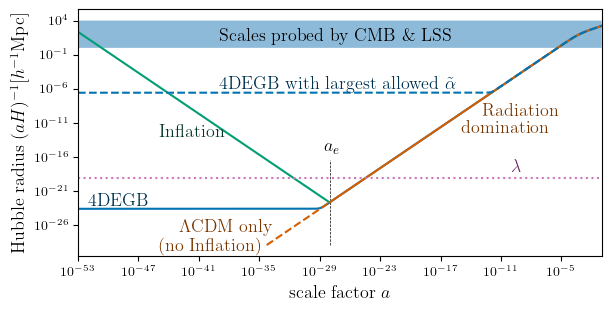

In [407]:
'''Plots for particle horizon'''
cosmo = [0.264 , 0.0493 , 0 , Omg_rad, 1e-112, 0]
z_CMB_val = z_CMB(cosmo[1],(cosmo[0]+cosmo[1]),h)
fig = plt.figure(constrained_layout=True, figsize=(6, 3))

# Set the desired precision of Decimal
getcontext().prec = 120
alpha_t = Decimal('1e-112')
cosmotry = [Decimal('0.264'),Decimal('0.0493'),Decimal('0'),Decimal(str(Omg_rad)),alpha_t,Decimal('0')]
cosmotry_LCDM = [Decimal('0.264'),Decimal('0.0493'),Decimal('0'),Decimal(str(Omg_rad)),Decimal('0'),Decimal('0')]

a = np.logspace(-53,-1, int(1e3),dtype=np.dtype(Decimal))
for i in range(len(a)):
    a[i] = Decimal(a[i])

idx_a_e = find_nearest_idx(a, (alpha_t)**(Decimal('0.25')))

plt.plot((alpha_t)**(Decimal('0.25'))*np.ones(len(a[int(3*idx_a_e/4):int(5*idx_a_e/4)]),dtype=np.dtype(Decimal)), \
         Decimal('3e3')/(a[int(3*idx_a_e/4):int(5*idx_a_e/4)]*E(1/a[int(3*idx_a_e/4):int(5*idx_a_e/4)] - 1 , cosmotry_LCDM)), "k--", linewidth=0.5)


plt.plot(a, Decimal('3e3')/(a*E(1/a - 1 , cosmotry)), color = col[0])

plt.plot(a[:idx_a_e], Decimal('3e3')/(E(1/a[idx_a_e] - 1 , cosmotry_LCDM)) * 1/a[:idx_a_e], label = r"$\textrm{inflation}$", color = col[2])
plt.plot(a[idx_a_e:], Decimal('3e3')/(a[idx_a_e:]*E(1/a[idx_a_e:] - 1 , cosmotry_LCDM)), color = col[3])
plt.plot(a[int(3*idx_a_e/4):idx_a_e], Decimal('3e3')/(a[int(3*idx_a_e/4):idx_a_e]*E(1/a[int(3*idx_a_e/4):idx_a_e] - 1 , cosmotry_LCDM)), color = col[3], linestyle="--")

plt.text(1e-15, 1e-10, r"$\textrm{Radiation}\newline\textrm{domination}$", fontfamily = "Helvetica", color = lighten_color(col[3], 1.3), size=13)
plt.text(1e-45, 1e-13, r"$\textrm{Inflation}$", fontfamily = "Helvetica", color = lighten_color(col[2], 1.3), size=13)
plt.text(3e-29, 1e-15, r"$a_e$", fontfamily = "Helvetica", size=13)
plt.text(1e-52, 1e-23, r"$\textrm{4DEGB}$", fontfamily = "Helvetica", color = lighten_color(col[0], 1.3), size=13)
plt.text(1e-45, 1e-27, r"$\Lambda\textrm{CDM only}\newline\textrm{(no Inflation)}$", fontfamily = "Helvetica", color=lighten_color(col[3], 1.3), size=13)
plt.text(1e-39, 1e1, r"$\textrm{Scales probed by CMB \& LSS}$", fontfamily = "Helvetica", size=13)

cosmotry2 = [Decimal('0.264'),Decimal('0.0493'),Decimal('0'),Decimal(str(Omg_rad)),Decimal('1e-44'),Decimal('0')]
plt.plot(a, Decimal('3e3')/(a*E(1/a - 1 , cosmotry2)), color = col[0], linestyle = "--")
plt.text(1e-39, 1e-6, r"$\textrm{4DEGB with largest allowed }\tilde{\alpha}$", 
         fontfamily = "Helvetica", color = lighten_color(col[0], 1.3), size=13)

# primordial perts
plt.plot(a, Decimal('1e-19')*np.ones(len(a),dtype=np.dtype(Decimal)), color = col[4], linestyle=":")
plt.text(1e-10, 5e-19, r'$\lambda$',color = lighten_color(col[4], 1.9), size=13)

plt.fill_between(a, 1, 1e4, alpha = 0.5)

plt.xscale("log")
plt.yscale("log")
plt.xlim(1e-53,1e-1)
plt.xlabel(r"$\textrm{scale factor } a$", size=13)
plt.ylabel(r"$\textrm{Hubble radius }(aH)^{-1} [h^{-1}\textrm{Mpc]}$", size=13)
#plt.savefig("particlehorizon_paper.pdf")
plt.show()

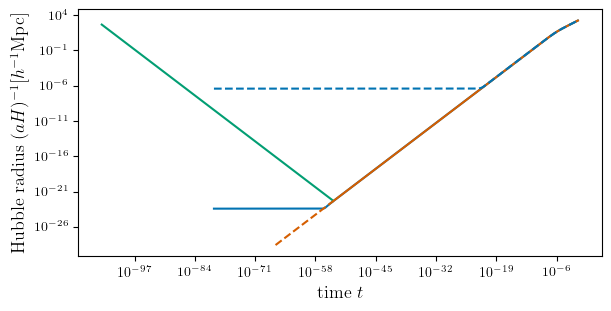

In [204]:
'''Plots for particle horizon as a function of time'''
mp.dps = 120

cosmo = [0.264 , 0.0493 , 0 , Omg_rad, 1e-112, 0]
z_CMB_val = z_CMB(cosmo[1],(cosmo[0]+cosmo[1]),h)
fig = plt.figure(constrained_layout=True, figsize=(6, 3))

# Set the desired precision of Decimal
getcontext().prec = 120
alpha_t = Decimal('1e-112')
cosmotry = [Decimal('0.264'),Decimal('0.0493'),Decimal('0'),Decimal(str(Omg_rad)),alpha_t,Decimal('0')]
cosmotry_LCDM = [Decimal('0.264'),Decimal('0.0493'),Decimal('0'),Decimal(str(Omg_rad)),Decimal('0'),Decimal('0')]

a = np.logspace(-53,-1, int(1e3),dtype=np.dtype(Decimal))
for i in range(len(a)):
    a[i] = Decimal(a[i])


idx_a_e = find_nearest_idx(a, (alpha_t)**(Decimal('0.25')))


plt.plot(time_4DEGB, Decimal('3e3')/(a*E(1/a - 1 , cosmotry)), color = col[0])

plt.plot(time_LCDM[:idx_a_e], Decimal('3e3')/(E(1/a[idx_a_e] - 1 , cosmotry_LCDM)) * 1/a[:idx_a_e], label = r"$\textrm{inflation}$", color = col[2])
plt.plot(time_LCDM[idx_a_e:], Decimal('3e3')/(a[idx_a_e:]*E(1/a[idx_a_e:] - 1 , cosmotry_LCDM)), color = col[3])
plt.plot(time_LCDM[int(3*idx_a_e/4):idx_a_e], Decimal('3e3')/(a[int(3*idx_a_e/4):idx_a_e]*E(1/a[int(3*idx_a_e/4):idx_a_e] - 1 , cosmotry_LCDM)), color = col[3], linestyle="--")

#plt.text(1e-15, 1e-10, r"$\textrm{Radiation}\newline\textrm{domination}$", fontfamily = "Helvetica", color = lighten_color(col[3], 1.3), size=13)
#plt.text(1e-45, 1e-13, r"$\textrm{Inflation}$", fontfamily = "Helvetica", color = lighten_color(col[2], 1.3), size=13)
#plt.text(3e-29, 1e-15, r"$a_e$", fontfamily = "Helvetica", size=13)
#plt.text(1e-52, 1e-23, r"$\textrm{4DEGB}$", fontfamily = "Helvetica", color = lighten_color(col[0], 1.3), size=13)
#plt.text(1e-45, 1e-27, r"$\Lambda\textrm{CDM only}\newline\textrm{(no Inflation)}$", fontfamily = "Helvetica", color=lighten_color(col[3], 1.3), size=13)
#plt.text(1e-39, 1e1, r"$\textrm{Scales probed by CMB \& LSS}$", fontfamily = "Helvetica", size=13)

cosmotry2 = [Decimal('0.264'),Decimal('0.0493'),Decimal('0'),Decimal(str(Omg_rad)),Decimal('1e-44'),Decimal('0')]
plt.plot(time_4DEGB, Decimal('3e3')/(a*E(1/a - 1 , cosmotry2)), color = col[0], linestyle = "--")
#plt.text(1e-39, 1e-6, r"$\textrm{4DEGB with largest allowed }\tilde{\alpha}$", 
#         fontfamily = "Helvetica", color = lighten_color(col[0], 1.3), size=13)

#plt.fill_between(a, 1, 1e4, alpha = 0.5)

plt.xscale("log")
plt.yscale("log")
#plt.xlim(1e-53,1e-1)
plt.xlabel(r"$\textrm{time } t$", size=13)
plt.ylabel(r"$\textrm{Hubble radius }(aH)^{-1} [h^{-1}\textrm{Mpc]}$", size=13)
#Earlyplt.savefig("particlehorizon_paper.pdf")
plt.show()


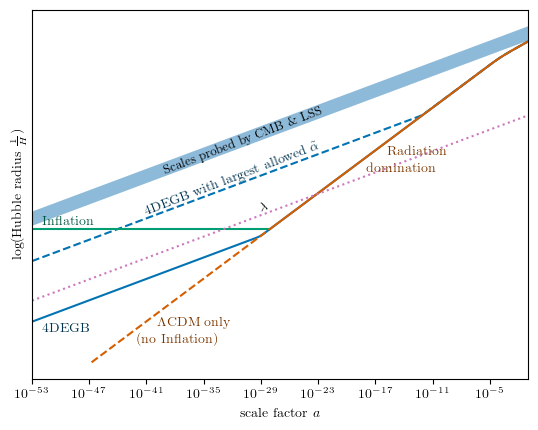

In [189]:
'''Plots for particle horizon - seed perturbations'''
# plots inspired by https://ned.ipac.caltech.edu/level5/Narlikar/Narlikar3_1.html
h = 0.67
cosmo = [0.264 , 0.0493 , 0 , Omg_rad, 1e-112, 0]
z_CMB_val = z_CMB(cosmo[1],(cosmo[0]+cosmo[1]),h)

# Set the desired precision of Decimal
getcontext().prec = 120
alpha_t = Decimal('1e-112')
cosmotry = [Decimal('0.264'),Decimal('0.0493'),Decimal('0'),Decimal(str(Omg_rad)),alpha_t,Decimal('0')]
cosmotry2 = [Decimal('0.264'),Decimal('0.0493'),Decimal('0'),Decimal(str(Omg_rad)),Decimal('1e-44'),Decimal('0')]

cosmotry_LCDM = [Decimal('0.264'),Decimal('0.0493'),Decimal('0'),Decimal(str(Omg_rad)),Decimal('0'),Decimal('0')]

a = np.logspace(-53,-1, int(1e3),dtype=np.dtype(Decimal))
for i in range(len(a)):
    a[i] = Decimal(a[i])

idx_a_e = find_nearest_idx(a, (alpha_t)**(Decimal('0.25')))

plt.fill_between(a, a, Decimal('1e4')*a, alpha = 0.5)
plt.text(1e-39, 4e-39, r"$\textrm{\small Scales probed by CMB \& LSS}$", color = 'k', rotation = 21,
         rotation_mode = 'anchor')

plt.plot(a, 1/(E(1/a - 1 , cosmotry)), color = col[0])
plt.plot(a, 1/(E(1/a - 1 , cosmotry2)), color = col[0], linestyle = "--")

plt.plot(a[:idx_a_e], 1/(E(1/a[idx_a_e] - 1 , cosmotry_LCDM))*np.ones(len(a[:idx_a_e]),dtype=np.dtype(Decimal)), label = r"$\textrm{inflation}$", color = col[2])
plt.plot(a[idx_a_e:], 1/(E(1/a[idx_a_e:] - 1 , cosmotry_LCDM)), color = col[3])
plt.plot(a[int(idx_a_e/4):idx_a_e], 1/(E(1/a[int(idx_a_e/4):idx_a_e] - 1 , cosmotry_LCDM)), color = col[3], linestyle="--")
plt.plot(a, Decimal('1e-21')*a, color = col[4], linestyle=":")
#plt.plot(a, Decimal('0.005')*a, color = col[4], linestyle=":")

plt.text(1e-18, 1e-33, r"$\textrm{Radiation}\newline\textrm{domination}$", fontfamily = "Helvetica", color = lighten_color(col[3], 1.3))
plt.text(1e-52, 1e-53, r"$\textrm{Inflation}$", fontfamily = "Helvetica", color = lighten_color(col[2], 1.2))
plt.text(1e-52, 1e-83, r"$\textrm{4DEGB}$", fontfamily = "Helvetica", color = lighten_color(col[0], 1.3))
plt.text(1e-41, 1e-50, r"$\textrm{4DEGB with largest allowed }\tilde{\alpha}$", 
         fontfamily = "Helvetica", color = lighten_color(col[0], 1.3), rotation = 21,
         rotation_mode = 'anchor')
plt.text(1e-42, 1e-81, r"$\Lambda\textrm{CDM only}\newline\textrm{(no Inflation)}$", fontfamily = "Helvetica", color = lighten_color(col[3], 1.3))

plt.text(1e-29, 1e-49, r'$\lambda$',
         color = 'k', rotation = 21,
         rotation_mode = 'anchor')

plt.xscale("log")
plt.yscale("log")
plt.xlim(1e-53,1e-1)
plt.xlabel(r"$\textrm{scale factor } a$")
plt.ylabel(r"$\textrm{log}(\textrm{Hubble radius } \frac{1}{H})$")
plt.gca().axes.get_yaxis().set_ticks([])
#plt.savefig("particlehorizon_lengths_paper.pdf")
plt.show()

## Perturbations

In [94]:
""" Define cosmology and scales """
# ---- COSMOLOGY, SCALES AND BOUNDARY CONDITIONS -----

# note: k is unitless (ie. k is actually k/H0)
# for simga_8, k = 2pi/(8h^-1 Mpc) \implies k/H0 = 3e5*pi/400

k_val = np.logspace(-3, 0, 300)*(3e5/100)

# Decide on some coordinate times
x_val = np.linspace( -2, 0 , 100)
a_val = np.exp(x_val)
z_val = 1/a_val - 1

# Decide on some background cosmology = Omega_c , Omega_b , Omega_k , Omega_r , alpha_C
cosmo_LCDM_array = [0.27 , 0.045, 0 ,9.227e-5 , 0.0]
cosmo = [0.27 , 0.045, 0 ,9.227e-5 , 1e-5]

# Background cosmology for pyccl
cosmoLCDM = ccl.core.Cosmology(Omega_c=cosmo[0],
                               Omega_b=cosmo[1], 
                               sigma8=0.81,
                               h = 0.67,
                               n_s=0.96,
                               Omega_k=cosmo[2], 
                               Omega_g=cosmo[3])

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

idx_sigma = find_nearest(k_val, 3e5*np.pi/400)
print("error in k_simga8 = ", 100*abs(3e5*np.pi/400 - k_val[idx_sigma])/(3e5*np.pi/400), "%")

error in k_simga8 =  1.0591568343275144 %


In [95]:
""" Find D+, f and fsigma8"""

solution_growth = solve_for_growth(a_val, cosmo, k_val)
solution_growth_LCDM = solve_for_growth(a_val, cosmo_LCDM_array, k_val)
# get LCDM for only some values of k for the plot to compare to 4DEGB
k_ex1 = k_val[int(len(k_val)/2)-5: int(len(k_val)/2) + 5]
solution_growth_LCDM_ex1 = solve_for_growth(a_val, cosmo_LCDM_array, k_ex1)

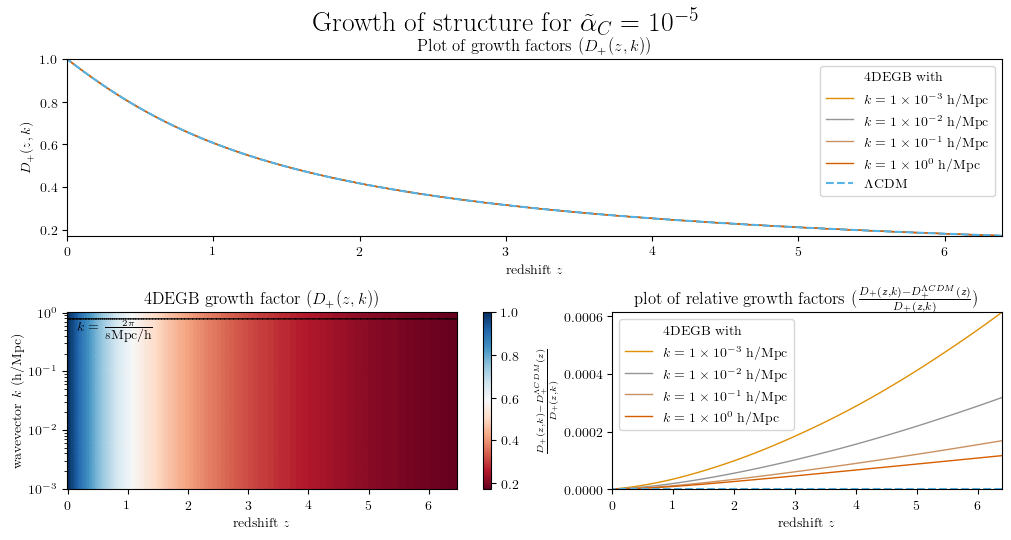

In [96]:
"""Linear Growth factor D+(a) plots"""

#fig, axs = plt.subplots(2, 2, figsize=(15, 10), sharex=True)
fig = plt.figure(constrained_layout=True, figsize=(10, 5))
axs = fig.subplot_mosaic([['Top', 'Top'],['BLeft', 'BRight']],
                          gridspec_kw={'width_ratios':[1, 1]})

col = sns.color_palette("colorblind") 
# best combinations are 0,2,4,9 and 1,3,5,8. Grey is 7

# X AND Y AXIS VALUES USED
# Full k space
X, Y = np.meshgrid(z_val, k_val/(3e5/100))
# k space for black lines
X_blackline, Y_blackline = np.meshgrid(z_val, [k_val[int(len(k_val)/2)-7]/(3e5/100),k_val[int(len(k_val)/2)-6]/(3e5/100)])
X_blackline1, Y_blackline1 = np.meshgrid(z_val, [k_val[int(len(k_val)/2)+5]/(3e5/100),k_val[int(len(k_val)/2)+6]/(3e5/100)])
# k value for 8 Mpc/h
X_8, Y_8 = np.meshgrid(z_val, [np.pi/4+0.005, np.pi/4 -0.005])
# CMB value
X_CMB, Y_CMB = np.meshgrid([1/1101 - 1e-6, 1/1101 + 1e-6] , k_val/(3e5/100))

"""
# PLOT OF RELATIVE D+(a)
ax = axs[1][0]
Z = (solution_growth[0]-solution_growth_LCDM[0])/solution_growth[0]
c = ax.pcolor(X, Y, Z,vmin=Z.min(), vmax=Z.max(), alpha = 1, cmap='RdBu')
ax.set_title(r'$\textrm{4DEGB growth factor relative to } \Lambda CDM \textrm{ }(\frac{D_{+}(z,k) - D_{+}^{\Lambda CDM}(z)}{D_{+}(z,k)})$')
ax.set_ylabel(r'$\textrm{wavevector }k \textrm{ (h/Mpc)}$')
# Line for CMB
#c2 = ax.pcolor(X_CMB, Y_CMB, np.zeros((len(k_val),2)), vmin=-10, vmax=0, alpha = 0.5, cmap='Greys')
#ax.text(1e-3, 0.5, r"CMB")
fig.colorbar(c, ax=ax)
ax.set_yscale("log")
ax.set_xlabel(r'$\textrm{redshift }z$')
"""
# PLOTS OF D+(a) OF 4DEGB AND LCDM
ax = axs['BLeft']
Z = solution_growth[0]
# Plot of 4DEGB growth rate
c = ax.pcolor(X, Y, Z, vmin=Z.min(), vmax=Z.max(), alpha = 1, cmap='RdBu')
# Line for 8 Mpc/h ---- TODO ------------------------------------------------------------------------------------
c2 = ax.pcolor(X_8, Y_8, np.zeros((2,len(z_val))), vmin=-10, vmax=0, alpha = 0.5, cmap='Greys')
ax.text(0.15, 5e-1, r"$k = \frac{2 \pi}{8\textrm{Mpc/h}}$")
# Line for CMB
#c2 = ax.pcolor(X_CMB, Y_CMB, np.zeros((len(k_val),2)), vmin=-10, vmax=0, alpha = 0.5, cmap='Greys')
#ax.text(1e-3, 0.5, r"CMB")

ax.set_title(r'$\textrm{4DEGB growth factor }(D_{+}(z,k))$')
ax.set_ylabel(r'$\textrm{wavevector }k\textrm{ (h/Mpc)}$')
ax.set_yscale("log")
ax.set_xlabel(r"$\textrm{redshift }z$")

fig.colorbar(c, ax=ax, pad=-0.02)

# 2D PLOTS OF D+(a)
ax = axs['Top']
ax.plot(1,0, alpha = 0, label = r"$\textrm{4DEGB with}$")
ax.plot(z_val, Z[0], label = r"$k = %.0f \times 10^{%d} \textrm{ h/Mpc}$" % \
        (10**(np.log10(k_val[0]/3000)-int(np.log10(k_val[0]/3000)-0.1)), int(np.log10(k_val[0]/3000)-0.1))\
        , linewidth =1, color = col[1])
ax.plot(z_val, Z[-280], label = r"$k = %.0f \times 10^{%d} \textrm{ h/Mpc}$" % \
        (10**(np.log10(k_val[-200]/3000)-int(np.log10(k_val[-200]/3000)-0.1)), int(np.log10(k_val[-200]/3000)-0.1))\
        , linewidth =1, color = col[7])
ax.plot(z_val, Z[-250], label = r"$k = %.0f \times 10^{%d} \textrm{ h/Mpc}$" % \
        (10**(np.log10(k_val[-100]/3000)-int(np.log10(k_val[-100]/3000) -0.1)), int(np.log10(k_val[-100]/3000)-0.1))\
        , linewidth =1, color = col[5])
ax.plot(z_val, Z[-1], label = r"$k = %.0f \times 10^{%d} \textrm{ h/Mpc}$" % \
        (10**(np.log10(k_val[-1]/3000)-int(np.log10(k_val[-1]/3000)-0.1)), int(np.log10(k_val[-1]/3000)-0.1))\
        , linewidth =1, color = col[3])
ax.plot(z_val, solution_growth_LCDM[0][int(len(k_val)/2)], color = col[9], linestyle = "--", label = r"$\Lambda \textrm{CDM}$")
#CMB
#ax.plot(1/1101*np.ones(len(z_val)), np.linspace(0,1,len(z_val)), linestyle = "--", color = "k")
#ax.text(1e-3, 0.5, r"CMB")

#ax.text(1e-4, 0.2e-3, r"$\Lambda CDM$")
ax.set_ylabel(r"$D_{+}(z,k)$")
ax.set_xlim(z_val[-1],z_val[0])
ax.set_ylim(solution_growth_LCDM[0][int(len(k_val)/2)][0],solution_growth_LCDM[0][int(len(k_val)/2)][-1])
ax.set_title(r'$\textrm{Plot of growth factors }(D_{+}(z,k))$')
ax.set_xlabel(r"$\textrm{redshift }z$")
ax.legend()

# 2D PLOTS OF RELATIVE D+(a)
ax = axs['BRight']
ax.plot(1,0, alpha = 0, label = r"\textrm{4DEGB with}")
Z = (solution_growth[0]-solution_growth_LCDM[0])/solution_growth[0]
ax.plot(z_val, Z[0], label = r"$k = %.0f \times 10^{%d} \textrm{ h/Mpc}$" % \
        (10**(np.log10(k_val[0]/3000)-int(np.log10(k_val[0]/3000)-0.1)), int(np.log10(k_val[0]/3000)-0.1))\
        , linewidth =1, color = col[1])
ax.plot(z_val, Z[-280], label = r"$k = %.0f \times 10^{%d} \textrm{ h/Mpc}$" % \
        (10**(np.log10(k_val[-200]/3000)-int(np.log10(k_val[-200]/3000)-0.1)), int(np.log10(k_val[-200]/3000)-0.1))\
        , linewidth =1, color = col[7])
ax.plot(z_val, Z[-250], label = r"$k = %.0f \times 10^{%d} \textrm{ h/Mpc}$" % \
        (10**(np.log10(k_val[-100]/3000)-int(np.log10(k_val[-100]/3000) -0.1)), int(np.log10(k_val[-100]/3000)-0.1))\
        , linewidth =1, color = col[5])
ax.plot(z_val, Z[-1], label = r"$k = %.0f \times 10^{%d} \textrm{ h/Mpc}$" % \
        (10**(np.log10(k_val[-1]/3000)-int(np.log10(k_val[-1]/3000)-0.1)), int(np.log10(k_val[-1]/3000)-0.1))\
        , linewidth =1, color = col[3])
ax.plot(z_val, np.zeros(len(z_val)), color = col[9], linestyle = "--")
#CMB
#ax.plot(1/1101*np.ones(len(z_val)), np.linspace(0,1,len(z_val)), linestyle = "--", color = "k")
#ax.text(1e-3, 0.9, r"CMB")

#ax.plot(z_val, solution_growth_LCDM[0][int(len(k_val)/2)], label = "LCDM", color = col[9])
ax.legend()
ax.set_title(r'$\textrm{plot of relative growth factors }(\frac{D_{+}(z,k) - D_{+}^{\Lambda CDM}(z)}{D_{+}(z,k)})$')
ax.set_ylabel(r"$\frac{D_{+}(z,k) - D_{+}^{\Lambda CDM}(z)}{D_{+}(z,k)}$")
ax.set_xlabel(r"$\textrm{redshift }z$")
ax.set_xlim(z_val[-1],z_val[0])
ax.set_ylim(Z[0][-1],Z[0][0])
#plt.pcolor(X_LCDM, Y_LCDM, np.zeros((len(k_val[450:550]),len(z_val))))
#fig.tight_layout()
fig.suptitle(r'$\textrm{Growth of structure for } \tilde{\alpha}_C = 10^{-5}$', fontsize=20, y=1.05)
#plt.savefig("Growth_LSS_regimes.pdf", bbox_inches='tight')
plt.show()

In [107]:
# Define new scales for CMB comparison
k_val = np.logspace(-3, 0, 300)*(3e5/100)

# Decide on some coordinate times
x_val = np.linspace( -9, 0 , 100)
a_val = np.exp(x_val)
z_val = 1/a_val - 1

# Decide on some background cosmology = Omega_c , Omega_b , Omega_k , Omega_r , alpha_C
cosmo_LCDM_array = [0.27 , 0.045, 0 ,9.227e-5 , 0.0]
cosmo = [0.27 , 0.045, 0 ,9.227e-5 , 1e-3]

# Background cosmology for pyccl
cosmoLCDM = ccl.core.Cosmology(Omega_c=cosmo[0],
                               Omega_b=cosmo[1], 
                               sigma8=0.81,
                               h = 0.67,
                               n_s=0.96,
                               Omega_k=cosmo[2], 
                               Omega_g=cosmo[3])

""" Find D+, f and fsigma8"""

solution_growth = solve_for_growth(a_val, cosmo, k_val)
solution_growth_LCDM = solve_for_growth(a_val, cosmo_LCDM_array, k_val)
# get LCDM for only some values of k for the plot to compare to 4DEGB
k_ex1 = k_val[int(len(k_val)/2)-5: int(len(k_val)/2) + 5]
solution_growth_LCDM_ex1 = solve_for_growth(a_val, cosmo_LCDM_array, k_ex1)

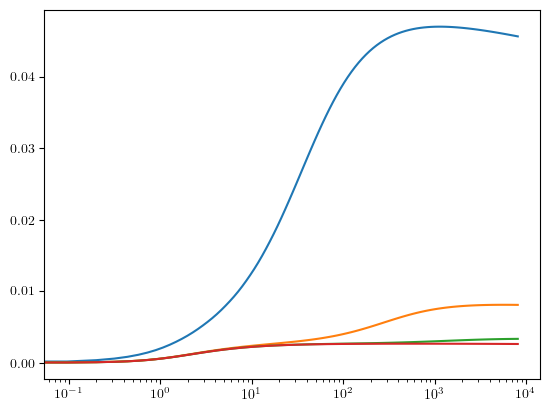

In [108]:
Z = (solution_growth[0]-solution_growth_LCDM[0])

plt.plot(z_val, Z[0])
plt.plot(z_val, Z[-200])
plt.plot(z_val, Z[-100])
plt.plot(z_val, Z[-1])
plt.xscale("log")